# English Premier League - 38 Matchday Prediction + Weekly predictions

Now, I'm not necessarily a fan of any EPL team since I'm a Bayern Munich fan (from the Bundesliga) but I do enjoy watching some matches as their matches are very entertaining. For starters they do spend a lot of money on players such as Liverpool spending money on Isak and Wirtz. I wanted to predict the table and well, see how that goes. This helps me hedge my risk in deciding who will win for my football bets. 

In [1]:
# Future
from __future__ import annotations

# Standard library
import io
import math
import re
import warnings
import calendar
import time
import datetime as dt
from pathlib import Path
from collections import defaultdict, deque
from typing import Optional, Dict, Tuple, List

# Third-party core
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
)

# NLP (sentiment)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
VADER = SentimentIntensityAnalyzer()

# Settings
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 200)
warnings.filterwarnings("ignore")

#  Query window for historical seasons
# football-data.co.uk uses two-digit start years (e.g., 12 -> 2012/13, 24 -> 2024/25)
SEASON_START: int = 12
SEASON_END:   int = 24

#  Endpoints // Collect more data
FD_BASE: str   = "https://www.football-data.co.uk/mmz4281/{code}/E0.csv"   # Premier League = E0
# Github repository has some good data here
GH_MIRROR: str = "https://raw.githubusercontent.com/footballcsv/cache.footballdata/master/mmz/england/{code}.csv"

# Local cache and save into folder
CACHE_DIR: Optional[Path] = Path("data_cache")    # put your E0_XXXX.csv here from the github above
if CACHE_DIR is not None:
    CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Labels (1X2)
LABEL_MAP = {"H": 2, "D": 1, "A": 0}
INV_LABEL = {v: k for k, v in LABEL_MAP.items()}

# HTTP session
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "EPL-RF/1.0 (+https://football-data.co.uk)"})

# Global RNG
RANDOM_STATE = 42

warnings.filterwarnings("ignore")


## EPL data fetch (cache → primary → mirror)

Collect more data and save as a dataframe

In [2]:
# Data acquisition: fetch season CSVs with mirror fallback & optional local cache
def season_code(yy: int) -> str:
    """Two-digit start year -> '1213', '2425', etc."""
    return f"{yy:02d}{(yy + 1) % 100:02d}"


def _read_csv_bytes(content: bytes) -> pd.DataFrame:
    """Robust CSV read from bytes."""
    return pd.read_csv(io.BytesIO(content))


def fetch_season_csv(
    yy: int,
    session: requests.Session = SESSION,
    cache_dir: Optional[Path] = CACHE_DIR,
) -> pd.DataFrame:
    """
    Fetch one season of E0 results.
    Priority: local cache → football-data → GitHub mirror.
    """
    code = season_code(yy)
    cache_path = (cache_dir / f"E0_{code}.csv") if cache_dir is not None else None

    # 1) Local cache
    if cache_path is not None and cache_path.exists():
        return pd.read_csv(cache_path)

    # 2) football-data
    url_fd = FD_BASE.format(code=code)
    r = session.get(url_fd, timeout=20)
    if r.ok and len(r.content) > 300:
        df = _read_csv_bytes(r.content)
        if cache_path is not None:
            cache_path.write_bytes(r.content)
        return df

    # 3) GitHub mirror
    url_gh = GH_MIRROR.format(code=code)
    r2 = session.get(url_gh, timeout=20)
    r2.raise_for_status()
    df = _read_csv_bytes(r2.content)
    if cache_path is not None:
        cache_path.write_bytes(r2.content)
    return df


def load_epl_matches(
    start_yy: int = SEASON_START,
    end_yy: int = SEASON_END,
    session: requests.Session = SESSION,
    cache_dir: Optional[Path] = CACHE_DIR,
) -> pd.DataFrame:
    """
    Load multiple seasons into a single DataFrame with 'Season' code.
    """
    frames: list[pd.DataFrame] = []
    for yy in range(start_yy, end_yy + 1):
        try:
            df = fetch_season_csv(yy, session=session, cache_dir=cache_dir).copy()
            df["Season"] = season_code(yy)
            frames.append(df)
        except Exception as exc:
            print(f"[WARN] Failed {yy} ({season_code(yy)}): {exc}")

    if not frames:
        raise RuntimeError("No seasons loaded. Check season range or cache.")

    return pd.concat(frames, ignore_index=True)


## Asign Aliases

Collect data from other current/past EPL teams. Past EPL teams is important to see how promoted teams perform during their first flight back in english football

In [3]:
# Basic cleaning utilities: parse dates, normalize team names

TEAM_ALIASES: dict[str, str] = {
    # Common short names → canonical names
    "Man United": "Manchester United",
    "Man Utd": "Manchester United",
    "Man City": "Manchester City",
    "Tottenham": "Tottenham Hotspur",
    "Spurs": "Tottenham Hotspur",
    "Nott'm Forest": "Nottingham Forest",
    "Wolves": "Wolverhampton Wanderers",
    "West Brom": "West Bromwich Albion",
    "Brighton": "Brighton and Hove Albion",
    "Newcastle": "Newcastle United",
    "Leeds": "Leeds United",
    "Bournemouth": "AFC Bournemouth",
    "West Ham": "West Ham United",
    "Sheffield Utd": "Sheffield United",
    # idempotent
    "Sheffield United": "Sheffield United",
}


def normalize_team(name: str) -> str:
    """Map common aliases to canonical club names."""
    if pd.isna(name):
        return name
    return TEAM_ALIASES.get(str(name).strip(), str(name).strip())


def parse_dates(df: pd.DataFrame) -> pd.DataFrame:
    """Parse 'Date' (dd/mm/yy or dd/mm/yyyy) into pandas datetime."""
    if "Date" in df.columns:
        df = df.copy()
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    return df


def clean_matches(df: pd.DataFrame) -> pd.DataFrame:
    """
    Minimal cleaning: parse dates, normalize team names, keep rows with a final result (FTR).
    """
    need = {"HomeTeam", "AwayTeam", "FTR", "Date"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"Missing required columns: {sorted(miss)}")

    out = parse_dates(df).copy()
    out["HomeTeam"] = out["HomeTeam"].map(normalize_team)
    out["AwayTeam"] = out["AwayTeam"].map(normalize_team)
    out = out.dropna(subset=["FTR"]).reset_index(drop=True)
    return out


## Elo ratings (pre-match)

Adds pre-match Elo ratings per team (`EloHome_pre`, `EloAway_pre`) by walking matches chronologically, using logistic Elo with home-advantage and optional goal-margin multiplier.
Tune with `base_rating`, `k`, and `home_adv`; updates occur after each result using `FTR`, `FTHG`, and `FTAG`.
Use this to create stable strength features before modeling.


In [4]:
# Elo rating (pre-match ratings per team)

def elo_expected(ra: float, rb: float) -> float:
    """Expected score for A vs B (logistic Elo)."""
    return 1.0 / (1.0 + 10 ** ((rb - ra) / 400.0))


def elo_update(
    ra: float,
    rb: float,
    score_a: float,              # 1, 0.5, 0
    *,
    k: float = 20.0,
    home_adv: float = 60.0,
    is_home_a: bool = True,
    goal_diff: int | None = None,
) -> Tuple[float, float]:
    """Single-match Elo update with optional margin multiplier."""
    a_eff = ra + (home_adv if is_home_a else 0.0)
    b_eff = rb + (home_adv if not is_home_a else 0.0)

    ea = elo_expected(a_eff, b_eff)

    g = 1.0
    if goal_diff is not None:
        g = 1.0 if goal_diff == 1 else (1.5 if goal_diff == 2 else 1.75)

    delta = k * g * (score_a - ea)
    return ra + delta, rb - delta


def attach_elo(matches: pd.DataFrame, *, base_rating: float = 1500.0,
               k: float = 20.0, home_adv: float = 60.0) -> pd.DataFrame:
    """
    Attach pre-match Elo to matches:
      - Adds 'EloHome_pre', 'EloAway_pre'
      - Updates team ratings in chronological order using actual results
    """
    need = {"Date", "HomeTeam", "AwayTeam", "FTR", "FTHG", "FTAG"}
    miss = need - set(matches.columns)
    if miss:
        raise ValueError(f"attach_elo: missing {sorted(miss)}")

    df = matches.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True).copy()
    teams = pd.unique(pd.concat([df["HomeTeam"], df["AwayTeam"]]))
    ratings: Dict[str, float] = {t: float(base_rating) for t in teams}

    elo_h, elo_a = [], []
    for _, r in df.iterrows():
        h, a = r["HomeTeam"], r["AwayTeam"]
        r_h_pre = ratings.get(h, base_rating)
        r_a_pre = ratings.get(a, base_rating)
        elo_h.append(r_h_pre)
        elo_a.append(r_a_pre)

        ftr = r["FTR"]
        score_h = 1.0 if ftr == "H" else (0.5 if ftr == "D" else 0.0)

        try:
            gd = int(abs(float(r["FTHG"]) - float(r["FTAG"])))
        except Exception:
            gd = None

        new_h, new_a = elo_update(r_h_pre, r_a_pre, score_h, k=k, home_adv=home_adv, is_home_a=True, goal_diff=gd)
        ratings[h], ratings[a] = new_h, new_a

    df["EloHome_pre"] = elo_h
    df["EloAway_pre"] = elo_a
    return df


## Last-5 form features (pre-match)

Computes rolling, strictly prior form per team and attaches to each fixture: `H_/A_` (`rGF`, `rGA`, `rGD`, `rW`, `rD`, `rL`, `Last5_PPG`).
Builds a long per-team match history, shifts by 1 to avoid leakage, and applies a `window` (default 5).
Use to capture recent performance trends for modeling.


In [5]:
# Last-5 form features (strictly prior to each match)

def _points_from_ftr_for_side(ftr: str, side: str) -> int:
    """Points for side 'H' or 'A' from FTR."""
    if ftr == "D": return 1
    if (ftr == "H" and side == "H") or (ftr == "A" and side == "A"): return 3
    return 0


def attach_last5_form(matches: pd.DataFrame, *, window: int = 5) -> pd.DataFrame:
    """
    Adds last-5 rolling features BEFORE each match for both sides:
      H_/A_: rGF, rGA, rGD, rW, rD, rL, Last5_PPG
    """
    need = {"Date", "HomeTeam", "AwayTeam", "FTR", "FTHG", "FTAG"}
    miss = need - set(matches.columns)
    if miss:
        raise ValueError(f"attach_last5_form: missing {sorted(miss)}")

    df = matches.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True).copy()
    df["MatchID"] = np.arange(len(df))

    long_rows = []
    for i, r in df.iterrows():
        long_rows += [
            # Home perspective
            {"MatchID": i, "Date": r["Date"], "Team": r["HomeTeam"], "Opp": r["AwayTeam"], "Side": "H",
             "GF": float(r["FTHG"]), "GA": float(r["FTAG"]),
             "W": 1 if r["FTR"] == "H" else 0, "D": 1 if r["FTR"] == "D" else 0, "L": 1 if r["FTR"] == "A" else 0,
             "Pts": _points_from_ftr_for_side(r["FTR"], "H")},
            # Away perspective
            {"MatchID": i, "Date": r["Date"], "Team": r["AwayTeam"], "Opp": r["HomeTeam"], "Side": "A",
             "GF": float(r["FTAG"]), "GA": float(r["FTHG"]),
             "W": 1 if r["FTR"] == "A" else 0, "D": 1 if r["FTR"] == "D" else 0, "L": 1 if r["FTR"] == "H" else 0,
             "Pts": _points_from_ftr_for_side(r["FTR"], "A")},
        ]

    long = pd.DataFrame(long_rows).sort_values(["Team", "Date", "MatchID"]).reset_index(drop=True)

    def _roll(gr: pd.DataFrame) -> pd.DataFrame:
        gr = gr.sort_values(["Date", "MatchID"]).copy()
        for col in ["GF", "GA", "Pts", "W", "D", "L"]:
            gr[f"r{col}"] = gr[col].shift(1).rolling(window, min_periods=1).mean()
        gr["rGD"] = gr["rGF"] - gr["rGA"]
        return gr

    long = long.groupby("Team", group_keys=False).apply(_roll)

    home_feats = (
        long[long["Side"] == "H"][["MatchID", "rGF", "rGA", "rGD", "rPts", "rW", "rD", "rL"]]
        .rename(columns={"rGF":"H_rGF","rGA":"H_rGA","rGD":"H_rGD","rPts":"H_Last5_PPG","rW":"H_rW","rD":"H_rD","rL":"H_rL"})
    )
    away_feats = (
        long[long["Side"] == "A"][["MatchID", "rGF", "rGA", "rGD", "rPts", "rW", "rD", "rL"]]
        .rename(columns={"rGF":"A_rGF","rGA":"A_rGA","rGD":"A_rGD","rPts":"A_Last5_PPG","rW":"A_rW","rD":"A_rD","rL":"A_rL"})
    )

    out = (df.merge(home_feats, on="MatchID", how="left")
             .merge(away_feats, on="MatchID", how="left")
             .drop(columns=["MatchID"]))
    return out


## Rivalry & H2H features (pre-match)

Adds `H2H_H_win_rate`, `H2H_A_win_rate`, `H2H_draw_rate` from the last *n* meetings (default 5) strictly prior to each fixture, plus a binary `Rivalry` flag.
Rivalries come from a small predefined set, filtered to clubs present in the dataset; histories update **after** each row to avoid leakage.


In [6]:
# Rivalry & H2H features (dictionary-based, no CSV)

# Core rivalries (keep it focused on 25/26 likely clubs; we filter by actual clubs from fixtures)
RIVALRY_PAIRS_BASE: set[tuple[str, str]] = {
    # London / regional
    ("Arsenal", "Tottenham Hotspur"),
    ("Chelsea", "Tottenham Hotspur"),
    ("Chelsea", "Fulham"),
    ("West Ham United", "Tottenham Hotspur"),
    ("Crystal Palace", "Brighton and Hove Albion"),
    ("Brentford", "Fulham"),

    # North West / national
    ("Liverpool", "Everton"),
    ("Liverpool", "Manchester United"),
    ("Manchester City", "Manchester United"),

    # North / Yorkshire / NE
    ("Leeds United", "Manchester United"),
    ("Newcastle United", "Sunderland"),
}

def build_rivalry_set(current_clubs: set[str]) -> set[tuple[str, str]]:
    """Symmetric rivalries restricted to clubs present in the 25/26 fixtures."""
    out = set()
    for a, b in RIVALRY_PAIRS_BASE:
        if a in current_clubs and b in current_clubs:
            out.add((a, b)); out.add((b, a))
    return out


def attach_h2h_and_rivalry(matches: pd.DataFrame, *, n: int = 5, current_clubs: Optional[set[str]] = None) -> pd.DataFrame:
    """
    Add per-row H2H win rates over last n meetings BEFORE the match + binary Rivalry flag.
    Uses an in-memory rivalry dictionary (no CSV).
    """
    need = {"Date", "HomeTeam", "AwayTeam", "FTR"}
    miss = need - set(matches.columns)
    if miss:
        raise ValueError(f"attach_h2h_and_rivalry: missing {sorted(miss)}")

    df = matches.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True).copy()

    # Rivalries filtered to clubs that actually appear in fixtures / this dataset
    if current_clubs is None:
        current_clubs = set(pd.unique(pd.concat([df["HomeTeam"], df["AwayTeam"]])))
    rival_set = build_rivalry_set(current_clubs)

    pair_hist: Dict[Tuple[str, str], deque] = defaultdict(lambda: deque(maxlen=n))

    h2h_h, h2h_a, h2h_d, riv = [], [], [], []
    for _, r in df.iterrows():
        h, a = r["HomeTeam"], r["AwayTeam"]
        key = tuple(sorted((h, a)))
        hist = pair_hist[key]

        if len(hist) == 0:
            h2h_h.append(np.nan); h2h_a.append(np.nan); h2h_d.append(np.nan)
        else:
            wins_h = sum(1 for w in hist if w == h)
            wins_a = sum(1 for w in hist if w == a)
            draws  = sum(1 for w in hist if w is None)
            tot    = len(hist)
            h2h_h.append(wins_h / tot)
            h2h_a.append(wins_a / tot)
            h2h_d.append(draws  / tot)

        riv.append(1 if (h, a) in rival_set else 0)

        # Update with current outcome for future rows only
        if   r["FTR"] == "H": hist.append(h)
        elif r["FTR"] == "A": hist.append(a)
        else:                  hist.append(None)

    df["H2H_H_win_rate"] = h2h_h
    df["H2H_A_win_rate"] = h2h_a
    df["H2H_draw_rate"]  = h2h_d
    df["Rivalry"]        = riv
    return df


## Team-level aggregates 

Builds team features from external CSVs: players → wide per-team `P_*`, clubs → `C_*`, then merges as `H_*`/`A_*` onto fixtures.
Players CSV must have `metric, team_name, value`; clubs CSV must have `team_name`.
Errors are caught and logged as warnings; merges are left-joins.


In [7]:
# Asign team-level aggregates (players / clubs CSVs → prefixed features)

def _agg_players_to_team(players: pd.DataFrame) -> pd.DataFrame:
    """
    Expected columns: ['metric','team_name','value', ...]
    Output: wide per-team table with P_<metric> columns.
    """
    req = {"metric", "team_name", "value"}
    if not req <= set(players.columns):
        raise ValueError("players CSV must contain ['metric','team_name','value']")
    g = (players.groupby(["team_name", "metric"])["value"].sum().unstack("metric").fillna(0.0))
    g.columns = [f"P_{c}" for c in g.columns]
    return g.reset_index().rename(columns={"team_name": "Team"})


def _reshape_club_stats(clubs: pd.DataFrame) -> pd.DataFrame:
    """Prefix numeric club columns with C_ and rename team_name → Team."""
    if "team_name" not in clubs.columns:
        raise ValueError("club stats CSV must contain 'team_name'")
    out = clubs.copy().rename(columns={"team_name": "Team"})
    for c in out.columns:
        if c != "Team" and pd.api.types.is_numeric_dtype(out[c]):
            out = out.rename(columns={c: f"C_{c}"})
    return out


def attach_team_aggregates(
    matches: pd.DataFrame, *, players_csv: Optional[str] = None, clubs_csv: Optional[str] = None
) -> pd.DataFrame:
    df = matches.copy()
    if players_csv:
        try:
            P = _agg_players_to_team(pd.read_csv(players_csv))
            df = df.merge(P.add_prefix("H_").rename(columns={"H_Team": "HomeTeam"}), on="HomeTeam", how="left")
            df = df.merge(P.add_prefix("A_").rename(columns={"A_Team": "AwayTeam"}), on="AwayTeam", how="left")
        except Exception as e:
            print(f"[WARN] players agg: {e}")
    if clubs_csv:
        try:
            C = _reshape_club_stats(pd.read_csv(clubs_csv))
            df = df.merge(C.add_prefix("H_").rename(columns={"H_Team": "HomeTeam"}), on="HomeTeam", how="left")
            df = df.merge(C.add_prefix("A_").rename(columns={"A_Team": "AwayTeam"}), on="AwayTeam", how="left")
        except Exception as e:
            print(f"[WARN] club agg: {e}")
    return df


## Build training frame

End-to-end feature pipeline: loads & cleans matches, then adds Elo, last-5 form, H2H+rivalry, rest days, and optional team aggregates; finally maps `FTR` → target `y`.
Returns `(df, feat_cols)` where `feat_cols` includes core features plus any `H_P_*`, `A_P_*`, `H_C_*`, `A_C_*`.
Use to produce a modeling-ready frame for classification.


In [8]:
# Build training frame

def _attach_rest_days(df: pd.DataFrame) -> pd.DataFrame:
    """Days since last appearance BEFORE the match (RestH, RestA)."""
    need = {"Date", "HomeTeam", "AwayTeam"}
    if need - set(df.columns):
        raise ValueError("rest days: missing columns")
    out = df.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True).copy()
    out["RestH"] = np.nan; out["RestA"] = np.nan
    last_seen: Dict[str, pd.Timestamp] = {}
    for i, r in out.iterrows():
        d, h, a = r["Date"], r["HomeTeam"], r["AwayTeam"]
        out.at[i, "RestH"] = (d - last_seen[h]).days if h in last_seen else np.nan
        out.at[i, "RestA"] = (d - last_seen[a]).days if a in last_seen else np.nan
        last_seen[h] = d; last_seen[a] = d
    out["RestH"] = out["RestH"].fillna(7.0)
    out["RestA"] = out["RestA"].fillna(7.0)
    return out


def build_training_frame(
    *, season_start: int = SEASON_START, season_end: int = SEASON_END,
    players_csv: Optional[str] = None, clubs_csv: Optional[str] = None,
    current_clubs: Optional[set[str]] = None,
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Full pipeline: clean → Elo → last-5 → H2H+Rivalry → Rest → Aggregates → target y
    Returns df and feature list.
    """
    raw = load_epl_matches(season_start, season_end)
    raw = clean_matches(raw)

    # Ensure numeric goals exist
    for col in ["FTHG", "FTAG"]:
        if col not in raw.columns:
            raise ValueError(f"Missing column {col}")

    df = attach_elo(raw)
    df = attach_last5_form(df, window=5)
    df = attach_h2h_and_rivalry(df, n=5, current_clubs=current_clubs)
    df = _attach_rest_days(df)
    df = attach_team_aggregates(df, players_csv=players_csv, clubs_csv=clubs_csv)
    df["y"] = df["FTR"].map(LABEL_MAP).astype(int)

    base_feats = [
        "EloHome_pre", "EloAway_pre",
        "H_Last5_PPG", "A_Last5_PPG",
        "H_rGF", "H_rGA", "H_rGD", "H_rW", "H_rD", "H_rL",
        "A_rGF", "A_rGA", "A_rGD", "A_rW", "A_rD", "A_rL",
        "H2H_H_win_rate", "H2H_A_win_rate", "H2H_draw_rate",
        "Rivalry", "RestH", "RestA",
    ]
    extra = [c for c in df.columns if c.startswith(("H_P_", "A_P_", "H_C_", "A_C_")) and pd.api.types.is_numeric_dtype(df[c])]
    feat_cols = base_feats + extra
    return df, feat_cols


## Train RF with TimeSeriesSplit + calibrated probabilities

Builds the training frame, runs 5-fold `TimeSeriesSplit` with a `RandomForestClassifier`, then calibrates via isotonic (`CalibratedClassifierCV`) to get out-of-fold probabilities and metrics (accuracy, log loss, Brier) plus a confusion matrix and top feature importances.
Finally fits a calibrated model on all data and saves artifacts in `MODEL_BUNDLE` (`model`, `rf`, `train_df`, `X`, `y`, `oof_proba`, `feat_cols`, `cv_metrics`).


   fold  accuracy  logloss   brier
0     1    0.4957   1.0399  0.6196
1     2    0.5674   1.0411  0.5695
2     3    0.5176   1.0407  0.5942
3     4    0.5249   0.9927  0.5925
4     5    0.5589   1.0073  0.5723

Means -> Acc: 0.5329 LogLoss: 1.0244 Brier: 0.5896


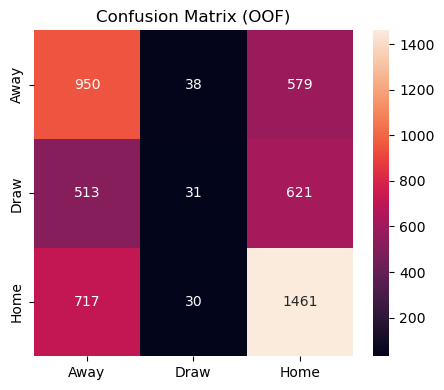

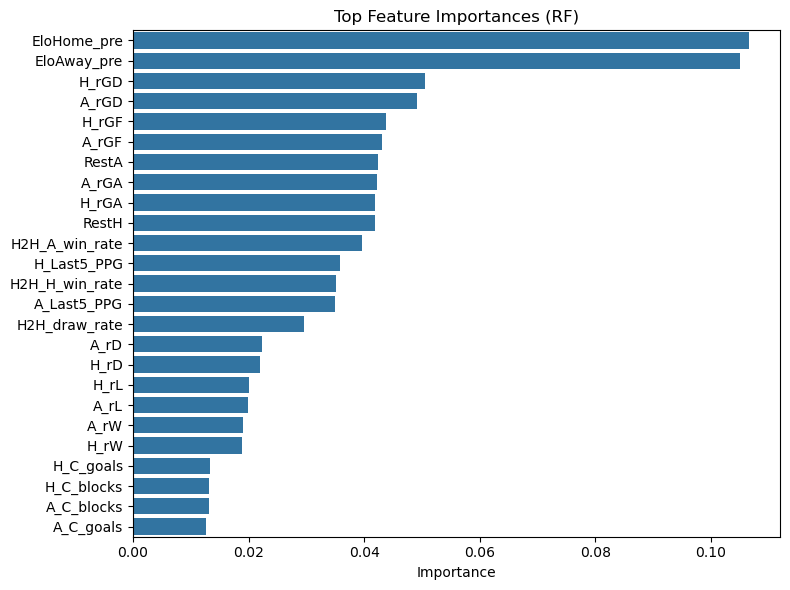

In [9]:
# Train Random Forest with TimeSeriesSplit CV + calibrated probs

def _first_existing(paths: list[str]) -> Optional[str]:
    for p in paths:
        if Path(p).exists():
            return p
    return None

PLAYERS_CSV = _first_existing(["pl_player_stats_players.csv"])
CLUBS_CSV   = _first_existing(["pl_club_stats.csv"])

# Determine current clubs from fixtures (so rivalries only include active clubs)
FIXTURES_CSV = _first_existing(["fixtures_2025_26.csv"])
if FIXTURES_CSV:
    fx = pd.read_csv(FIXTURES_CSV)
    current_clubs = set(pd.unique(pd.concat([fx["home"], fx["away"]])))
    current_clubs = {normalize_team(t) for t in current_clubs if isinstance(t, str)}
else:
    current_clubs = None

train_df, FEAT_COLS = build_training_frame(
    season_start=SEASON_START,
    season_end=SEASON_END,
    players_csv=PLAYERS_CSV,
    clubs_csv=CLUBS_CSV,
    current_clubs=current_clubs,
)

X = train_df[FEAT_COLS].fillna(0.0).astype(float).reset_index(drop=True)
y = train_df["y"].astype(int).reset_index(drop=True)

tscv = TimeSeriesSplit(n_splits=5)
oof_proba = np.zeros((len(X), 3), dtype=float)
fold_rows = []

for fold, (tr, va) in enumerate(tscv.split(X), start=1):
    rf = RandomForestClassifier(
        n_estimators=600, max_depth=None,
        min_samples_split=6, min_samples_leaf=2,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE + fold, n_jobs=-1,
    )
    rf.fit(X.iloc[tr], y.iloc[tr])

    cal = CalibratedClassifierCV(rf, method="isotonic", cv=3)
    cal.fit(X.iloc[tr], y.iloc[tr])

    proba = cal.predict_proba(X.iloc[va])
    oof_proba[va] = proba

    yhat = np.argmax(proba, axis=1)
    acc  = accuracy_score(y.iloc[va], yhat)
    ll   = log_loss(y.iloc[va], proba, labels=[0,1,2])
    eye = np.eye(3); y1 = eye[y.iloc[va].values]
    brier = np.mean(np.sum((proba - y1)**2, axis=1))
    fold_rows.append({"fold": fold, "accuracy": acc, "logloss": ll, "brier": brier})

cv_metrics = pd.DataFrame(fold_rows)
print(cv_metrics.round(4))
print("\nMeans -> Acc:", cv_metrics["accuracy"].mean().round(4),
      "LogLoss:", cv_metrics["logloss"].mean().round(4),
      "Brier:", cv_metrics["brier"].mean().round(4))

# Final model on all data
final_rf = RandomForestClassifier(
    n_estimators=800, max_depth=None,
    min_samples_split=6, min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE, n_jobs=-1,
)
final_rf.fit(X, y)
final_model = CalibratedClassifierCV(final_rf, method="isotonic", cv=3)
final_model.fit(X, y)

MODEL_BUNDLE: Dict[str, object] = {
    "model": final_model,
    "rf": final_rf,
    "train_df": train_df,
    "X": X, "y": y,
    "oof_proba": oof_proba,
    "feat_cols": FEAT_COLS,
    "cv_metrics": cv_metrics,
}

# --- Visuals
y_oof_hat = np.argmax(oof_proba, axis=1)
cm = confusion_matrix(y, y_oof_hat, labels=[0,1,2])

plt.figure(figsize=(4.6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Away","Draw","Home"],
            yticklabels=["Away","Draw","Home"])
plt.title("Confusion Matrix (OOF)"); plt.tight_layout(); plt.show()

imp = pd.Series(final_rf.feature_importances_, index=FEAT_COLS).sort_values(ascending=False).head(25)
plt.figure(figsize=(8,6)); sns.barplot(x=imp.values, y=imp.index)
plt.title("Top Feature Importances (RF)"); plt.xlabel("Importance"); plt.ylabel(""); plt.tight_layout(); plt.show()


# MD2 predictions from fixtures
Whole set of predictions incoming

## MD II V1 Prediction
* Builds MD2 feature rows from `fixtures_2025_26.csv` using MD1 + historical PL data (Elo, last-5 form, H2H, rest, optional team aggregates).
* Uses trained calibrated RF (`MODEL_BUNDLE`) to output class probabilities and picks; saves **`md2_predictions.csv`** and displays a tidy table.
* Prints OOF metrics (classification report, macro-F1, multiclass AUC) and shows confusion matrix, ROC curves, and a small feature scatterplot matrix.
* Gracefully fills missing trained features with 0 and logs which were absent.
* Rivalries restricted to active 25/26 clubs; all features computed strictly **before** each match date to avoid leakage.


,date,home,away,P_home,P_draw,P_away,Pick,PickTeam,ScoreHint
0,2025-08-22,West Ham United,Chelsea,0.271888,0.168088,0.560024,Away,Chelsea,1-2
1,2025-08-23,AFC Bournemouth,Wolverhampton Wanderers,0.629403,0.198282,0.172316,Home,AFC Bournemouth,2-1
2,2025-08-23,Arsenal,Leeds United,0.752697,0.175367,0.071936,Home,Arsenal,1-0
3,2025-08-23,Brentford,Aston Villa,0.412621,0.228796,0.358583,Home,Brentford,2-1
4,2025-08-23,Burnley,Sunderland,0.529206,0.227471,0.243322,Home,Burnley,2-1
5,2025-08-23,Manchester City,Tottenham Hotspur,0.736212,0.156422,0.107366,Home,Manchester City,2-1
6,2025-08-24,Crystal Palace,Nottingham Forest,0.510788,0.209101,0.280111,Home,Crystal Palace,3-2
7,2025-08-24,Everton,Brighton and Hove Albion,0.413312,0.287553,0.299135,Home,Everton,3-2
8,2025-08-24,Fulham,Manchester United,0.457768,0.248947,0.293285,Home,Fulham,2-1
9,2025-08-25,Newcastle United,Liverpool,0.470578,0.240028,0.289394,Home,Newcastle United,3-2


✔ Saved md2_predictions.csv

Classification report (OOF):
              precision    recall  f1-score   support

        Away       0.44      0.61      0.51      1567
        Draw       0.31      0.03      0.05      1165
        Home       0.55      0.66      0.60      2208

    accuracy                           0.49      4940
   macro avg       0.43      0.43      0.39      4940
weighted avg       0.46      0.49      0.44      4940

Macro F1 (OOF): 0.3854
Multiclass AUC (OvR): 0.6329


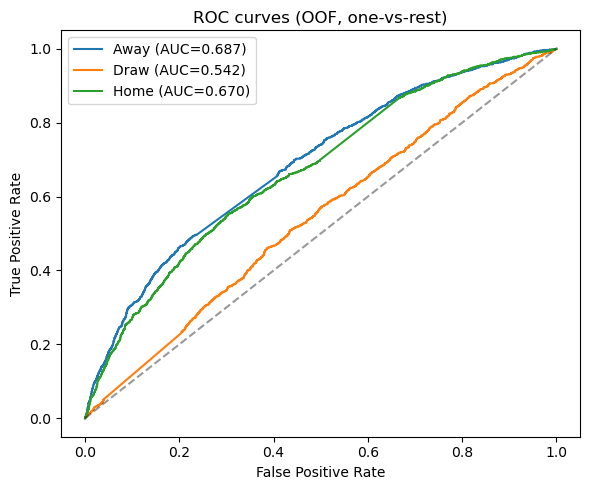

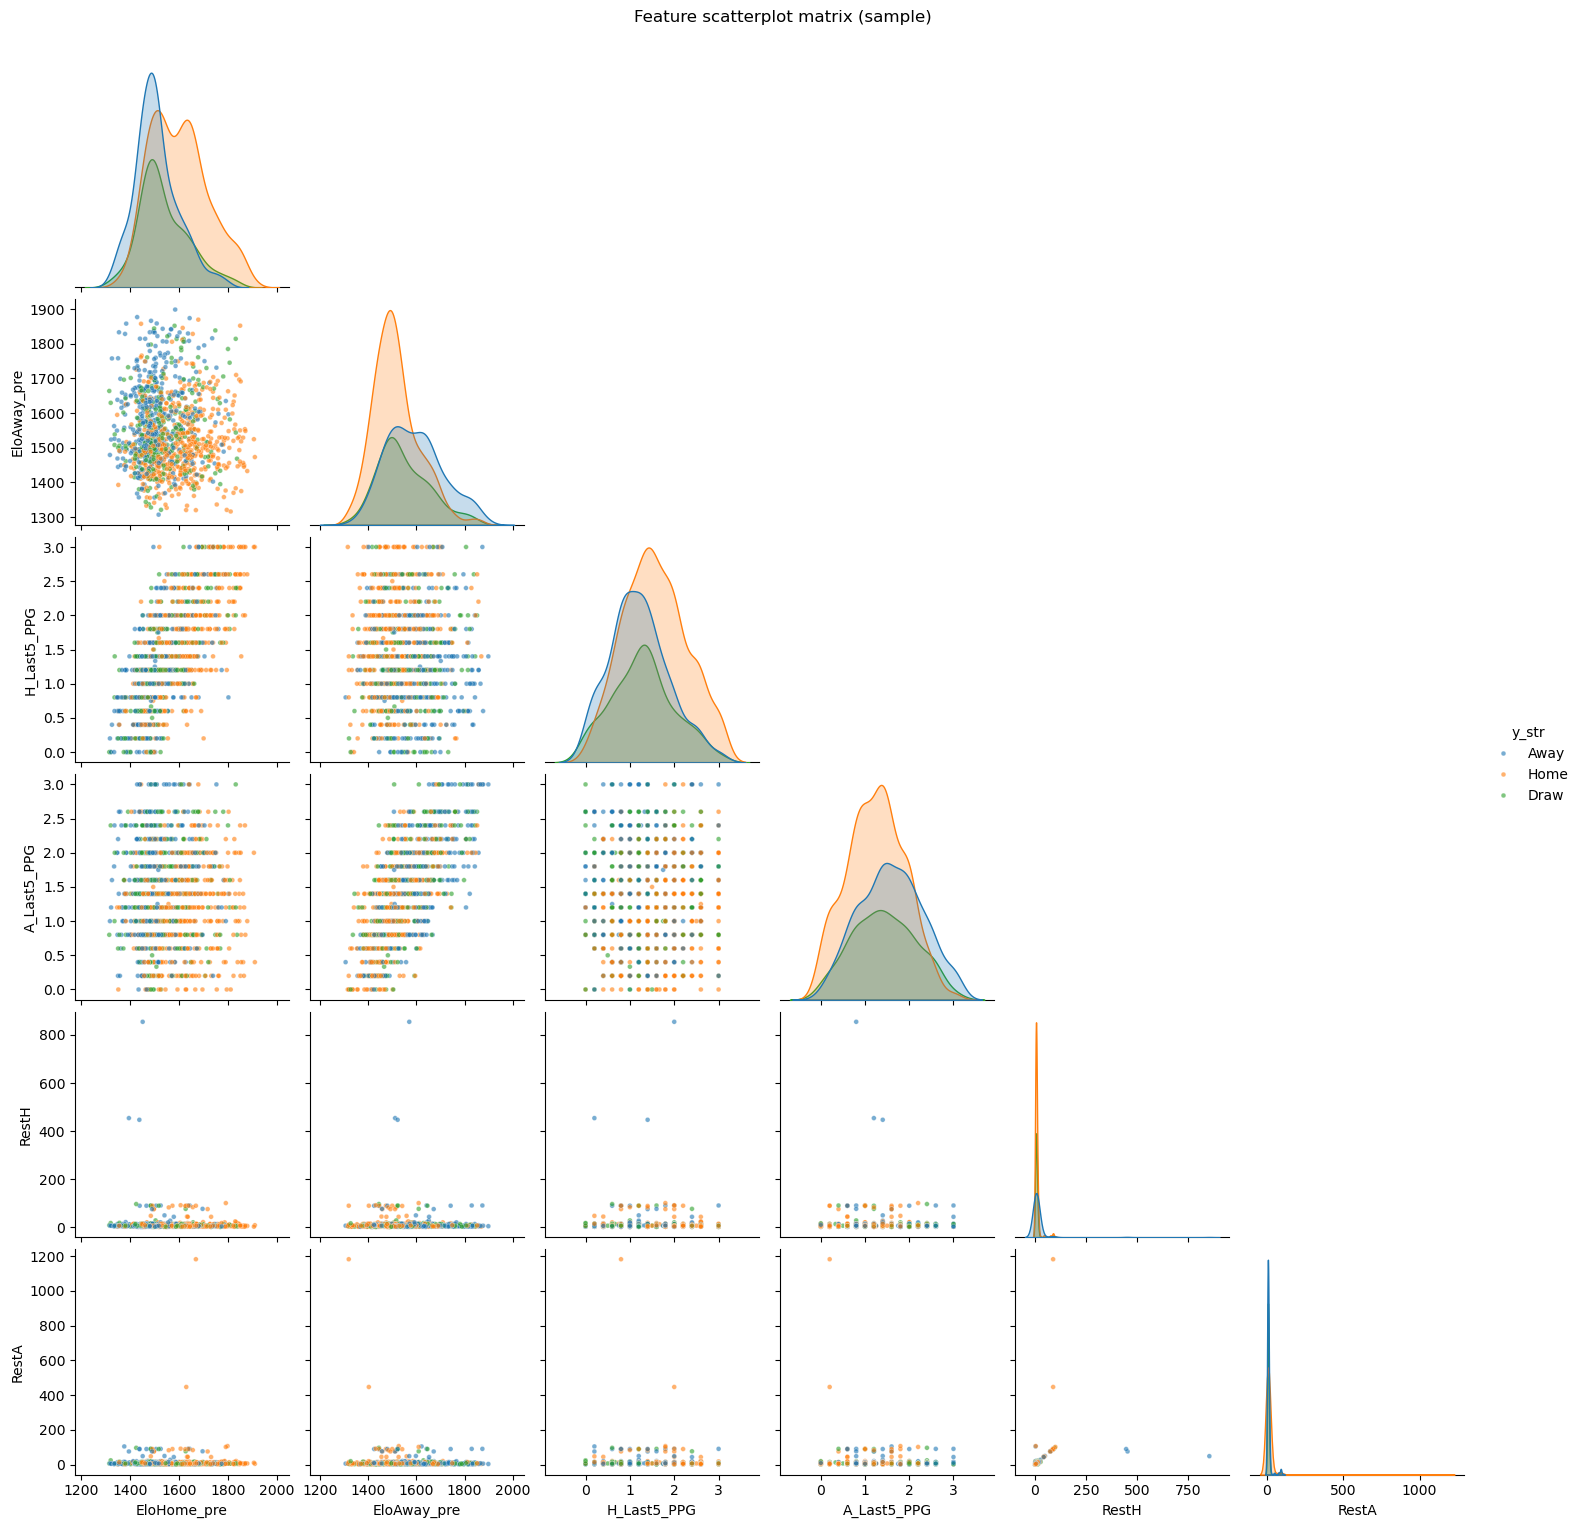

In [10]:
# set helper functions
def _first_existing(paths: list[str]) -> str | None:
    for p in paths:
        if Path(p).exists(): return p
    return None

def _side_last5_rates(history: pd.DataFrame, team: str, side: str, asof: pd.Timestamp, n:int=5) -> Dict[str,float]:
    """Last-5 averages for a team in home ('H') or away ('A') context strictly before `asof`."""
    h = history[history["Date"] < asof]
    if side == "H":
        h = h[h["HomeTeam"] == team].sort_values("Date").tail(n)
        if h.empty:
            return {"rGF":0.0,"rGA":0.0,"rW":0.0,"rD":0.0,"rL":0.0,"Last5_PPG":0.0}
        GF = h["FTHG"].astype(float).values
        GA = h["FTAG"].astype(float).values
        W  = (h["FTR"]=="H").astype(float).values
        D  = (h["FTR"]=="D").astype(float).values
        L  = (h["FTR"]=="A").astype(float).values
    else:
        h = h[h["AwayTeam"] == team].sort_values("Date").tail(n)
        if h.empty:
            return {"rGF":0.0,"rGA":0.0,"rW":0.0,"rD":0.0,"rL":0.0,"Last5_PPG":0.0}
        GF = h["FTAG"].astype(float).values
        GA = h["FTHG"].astype(float).values
        W  = (h["FTR"]=="A").astype(float).values
        D  = (h["FTR"]=="D").astype(float).values
        L  = (h["FTR"]=="H").astype(float).values

    m = len(GF)
    return {
        "rGF": GF.mean(),
        "rGA": GA.mean(),
        "rW":  W.mean(),
        "rD":  D.mean(),
        "rL":  L.mean(),
        "Last5_PPG": (3*W.sum() + 1*D.sum()) / m
    }

def _elo_dict_after(history: pd.DataFrame) -> Dict[str,float]:
    """Compute current Elo for all teams by walking through `history` chronologically."""
    hist_sorted = history.sort_values("Date")
    teams = pd.unique(pd.concat([hist_sorted["HomeTeam"], hist_sorted["AwayTeam"]]))
    ratings = {t:1500.0 for t in teams}
    for _, r in hist_sorted.iterrows():
        ra, rb = ratings[r["HomeTeam"]], ratings[r["AwayTeam"]]
        score_h = 1.0 if r["FTR"]=="H" else (0.5 if r["FTR"]=="D" else 0.0)
        try:
            gd = int(abs(float(r["FTHG"])-float(r["FTAG"])))
        except Exception:
            gd = None
        new_h, new_a = elo_update(ra, rb, score_h, k=20.0, home_adv=60.0, is_home_a=True, goal_diff=gd)
        ratings[r["HomeTeam"]], ratings[r["AwayTeam"]] = new_h, new_a
    return ratings

def _h2h_rates(history: pd.DataFrame, home: str, away: str, asof: pd.Timestamp, n:int=5) -> Tuple[float,float,float]:
    """Last N head-to-head meetings BEFORE `asof` (rates for home/away/draw)."""
    h = history[((history["HomeTeam"]==home)&(history["AwayTeam"]==away))|
                ((history["HomeTeam"]==away)&(history["AwayTeam"]==home))]
    h = h[h["Date"] < asof].sort_values("Date").tail(n)
    if h.empty: return (np.nan, np.nan, np.nan)
    wins_h = ((h["HomeTeam"]==home) & (h["FTR"]=="H")).sum() + ((h["AwayTeam"]==home) & (h["FTR"]=="A")).sum()
    wins_a = ((h["HomeTeam"]==away) & (h["FTR"]=="H")).sum() + ((h["AwayTeam"]==away) & (h["FTR"]=="A")).sum()
    draws  = (h["FTR"]=="D").sum()
    tot = len(h)
    return (wins_h/tot, wins_a/tot, draws/tot)

def _rest_days(history: pd.DataFrame, team: str, asof: pd.Timestamp) -> float:
    """Days since last appearance BEFORE `asof`."""
    h = history[((history["HomeTeam"]==team)|(history["AwayTeam"]==team)) & (history["Date"]<asof)]
    if h.empty: return 7.0
    last = h["Date"].max()
    return float((asof - last).days)

def _is_rivalry(h: str, a: str, rival_set: set[tuple[str,str]]) -> int:
    return 1 if (normalize_team(h), normalize_team(a)) in rival_set else 0

#  load fixtures 
FIXTURES_CSV = _first_existing(["fixtures_2025_26.csv"])
if not FIXTURES_CSV:
    raise FileNotFoundError("fixtures_2025_26.csv not found.")

fixtures = pd.read_csv(FIXTURES_CSV)
fixtures["date"] = pd.to_datetime(fixtures["date"], errors="coerce")
if "played" not in fixtures.columns:
    fixtures["played"] = fixtures["FTR"].notna()

# build 'history' (training results + MD1 from 25/26) 
hist = MODEL_BUNDLE["train_df"][["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]].dropna(subset=["FTR"]).copy()
hist = hist.sort_values("Date").reset_index(drop=True)

md1 = fixtures[(fixtures["md"] == 1) & (fixtures.get("FTR").notna())].copy()
if not md1.empty:
    md1_rows = md1.rename(columns={"date":"Date","home":"HomeTeam","away":"AwayTeam"})[["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]
    hist = pd.concat([hist, md1_rows], ignore_index=True).sort_values("Date").reset_index(drop=True)

# current rivalry universe restricted to active 25/26 clubs
active_clubs = set(pd.unique(pd.concat([fixtures["home"], fixtures["away"]]).dropna().map(normalize_team)))
rival_set = build_rivalry_set(active_clubs)

#  create MD2 feature rows 
md2 = fixtures[fixtures["md"] == 2].copy()
md2["home"] = md2["home"].map(normalize_team)
md2["away"] = md2["away"].map(normalize_team)

# predict for any not-yet-played in MD2; if already finished, still show the table
md2_target = md2[(~md2.get("played", False)) | (md2.get("FTR").isna())].copy()
if md2_target.empty:
    md2_target = md2.copy()

elo_now = _elo_dict_after(hist)

rows = []
for _, m in md2_target.iterrows():
    d = pd.to_datetime(m["date"])
    h, a = m["home"], m["away"]

    # Elo
    EloHome_pre = elo_now.get(h, 1500.0)
    EloAway_pre = elo_now.get(a, 1500.0)

    # Form (side-specific last 5)
    H5 = _side_last5_rates(hist, h, "H", d, n=5)
    A5 = _side_last5_rates(hist, a, "A", d, n=5)

    # H2H + rivalry + rest
    H2H_H, H2H_A, H2H_D = _h2h_rates(hist, h, a, d, n=5)
    Rivalry = _is_rivalry(h, a, rival_set)
    RestH = _rest_days(hist, h, d)
    RestA = _rest_days(hist, a, d)

    rows.append({
        "date": d, "home": h, "away": a,
        "EloHome_pre": EloHome_pre, "EloAway_pre": EloAway_pre,
        "H_Last5_PPG": H5["Last5_PPG"], "A_Last5_PPG": A5["Last5_PPG"],
        "H_rGF": H5["rGF"], "H_rGA": H5["rGA"], "H_rGD": H5["rGF"]-H5["rGA"],
        "H_rW": H5["rW"], "H_rD": H5["rD"], "H_rL": H5["rL"],
        "A_rGF": A5["rGF"], "A_rGA": A5["rGA"], "A_rGD": A5["rGF"]-A5["rGA"],
        "A_rW": A5["rW"], "A_rD": A5["rD"], "A_rL": A5["rL"],
        "H2H_H_win_rate": H2H_H, "H2H_A_win_rate": H2H_A, "H2H_draw_rate": H2H_D,
        "Rivalry": Rivalry, "RestH": RestH, "RestA": RestA
    })

pred_df = pd.DataFrame(rows)

# inject team aggregates to reduce missing features 
PLAYERS_CSV = _first_existing(["pl_player_stats_players.csv"])
CLUBS_CSV   = _first_existing(["pl_club_stats.csv"])

try:
    if PLAYERS_CSV or CLUBS_CSV:
        _stub = pred_df.rename(columns={"home":"HomeTeam","away":"AwayTeam"})[["HomeTeam","AwayTeam"]].copy()
        _stub = attach_team_aggregates(_stub, players_csv=PLAYERS_CSV, clubs_csv=CLUBS_CSV)
        for c in _stub.columns:
            if c.startswith(("H_P_","A_P_","H_C_","A_C_")):
                pred_df[c] = _stub[c]
except Exception as e:
    print("[WARN] couldn't add team aggregates:", e)

# ---------- build prediction matrix safely (fill unknown features with 0) ----------
FEATS = MODEL_BUNDLE["feat_cols"]
X_pred = pd.DataFrame(0.0, index=pred_df.index, columns=FEATS)          # start with zeros for all expected feats
copyable = [c for c in FEATS if c in pred_df.columns]
if copyable:
    X_pred[copyable] = pred_df[copyable].astype(float)

missing = [c for c in FEATS if c not in pred_df.columns]
if missing:
    print(f"[INFO] {len(missing)} trained features not present for MD2; filled with 0 "
          f"(e.g., {missing[:8]}{' ...' if len(missing)>8 else ''})")

# prediction 
proba = MODEL_BUNDLE["model"].predict_proba(X_pred)
pred_df["P_away"] = proba[:, 0]
pred_df["P_draw"] = proba[:, 1]
pred_df["P_home"] = proba[:, 2]

def _pick(row):
    idx = int(np.argmax([row["P_away"], row["P_draw"], row["P_home"]]))
    return ["Away","Draw","Home"][idx]

pred_df["Pick"] = pred_df.apply(_pick, axis=1)
pred_df["PickTeam"] = pred_df.apply(lambda r: r["away"] if r["Pick"]=="Away" else (r["home"] if r["Pick"]=="Home" else "Draw"), axis=1)

# simple score hint from Elo+form
def _score_hint(r):
    ediff = (r["EloHome_pre"] - r["EloAway_pre"]) / 400.0
    mu_h = np.clip(1.25 + 0.9*ediff + 0.6*(r["H_rGF"] - r["A_rGA"]), 0.2, 3.6)
    mu_a = np.clip(1.25 - 0.9*ediff + 0.6*(r["A_rGF"] - r["H_rGA"]), 0.2, 3.6)
    gh, ga = int(round(mu_h)), int(round(mu_a))
    if r["Pick"]=="Home" and gh <= ga: gh = ga + 1
    if r["Pick"]=="Away" and ga <= gh: ga = gh + 1
    if r["Pick"]=="Draw": gh = ga
    return f"{max(0,gh)}-{max(0,ga)}"

pred_df["ScoreHint"] = pred_df.apply(_score_hint, axis=1)

md2_preds = pred_df[["date","home","away","P_home","P_draw","P_away","Pick","PickTeam","ScoreHint"]]\
             .sort_values(["date","home"]).reset_index(drop=True)

display(md2_preds)
md2_preds.to_csv("md2_predictions.csv", index=False)
print("✔ Saved md2_predictions.csv")

# Evaluation on training (OOF) 
y_true = MODEL_BUNDLE["y"].values
oof_proba = MODEL_BUNDLE["oof_proba"].copy()

# Ensure rows are valid probabilities (sum to 1); renormalize if needed
row_sum = oof_proba.sum(axis=1, keepdims=True)
bad = (~np.isfinite(row_sum)) | (row_sum <= 0)
if bad.any():
    oof_proba[bad.ravel(), :] = 1.0 / 3
row_sum = oof_proba.sum(axis=1, keepdims=True)
oof_proba = oof_proba / np.clip(row_sum, 1e-12, None)

y_oof = np.argmax(oof_proba, axis=1)
print("\nClassification report (OOF):")
print(classification_report(y_true, y_oof, target_names=["Away","Draw","Home"]))
macro_f1 = f1_score(y_true, y_oof, average="macro")
print("Macro F1 (OOF):", round(macro_f1, 4))

# Multiclass AUC (OvR)
auc_ovr = roc_auc_score(y_true, oof_proba, multi_class="ovr")
print("Multiclass AUC (OvR):", round(auc_ovr, 4))

# ROC curves per class
y_bin = label_binarize(y_true, classes=[0,1,2])
fpr, tpr, rocA = {}, {}, {}
plt.figure(figsize=(6,5))
for i, name in enumerate(["Away","Draw","Home"]):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], oof_proba[:, i])
    rocA[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC={rocA[i]:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (OOF, one-vs-rest)")
plt.legend(); plt.tight_layout(); plt.show()


# Scatterplot matrix on a subset 
pair_cols = ["EloHome_pre","EloAway_pre","H_Last5_PPG","A_Last5_PPG","RestH","RestA"]
pp = MODEL_BUNDLE["train_df"][pair_cols + ["FTR"]].dropna().sample(
    min(1200, len(MODEL_BUNDLE["train_df"])), random_state=RANDOM_STATE
).copy()
pp["y_str"] = pp["FTR"].map({"A":"Away","D":"Draw","H":"Home"})
sns.pairplot(pp, vars=pair_cols, hue="y_str", corner=True, plot_kws={"s": 12, "alpha": 0.6})
plt.suptitle("Feature scatterplot matrix (sample)", y=1.02)
plt.show()


## Feature importance (trained RF)

Plots the top 25 features by `RandomForest` Gini importance and displays a table of the top 50 with numeric values.
Use this to sanity-check which signals (Elo, form, H2H, rest, aggregates) the model leans on most and to guide feature pruning or engineering.


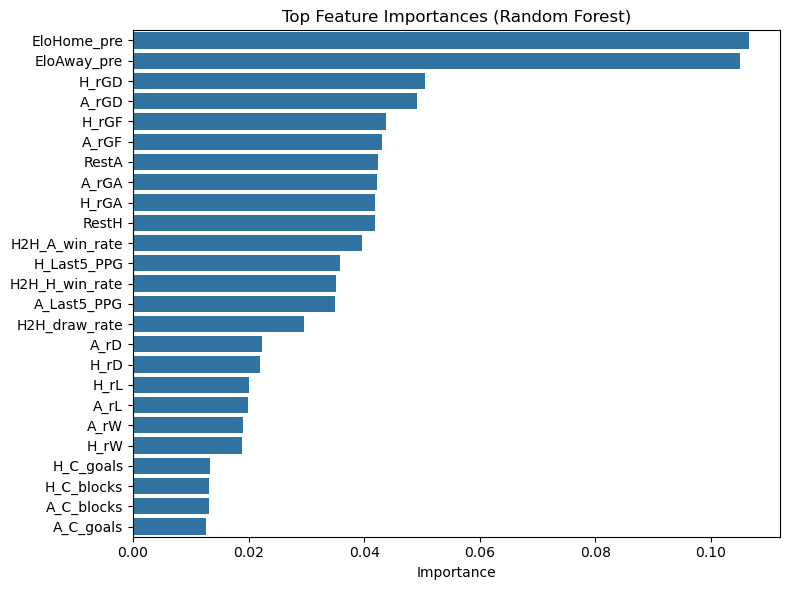

,importance
EloHome_pre,0.1067
EloAway_pre,0.1051
H_rGD,0.0505
A_rGD,0.0492
H_rGF,0.0437
A_rGF,0.0431
RestA,0.0425
A_rGA,0.0422
H_rGA,0.0420
RestH,0.0420


In [11]:
# Feature importance 
rf = MODEL_BUNDLE["rf"]
feats = MODEL_BUNDLE["feat_cols"]

imp = pd.Series(rf.feature_importances_, index=feats).sort_values(ascending=False)
top = imp.head(25)

plt.figure(figsize=(8, 6))
sns.barplot(x=top.values, y=top.index)
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(imp.head(50).to_frame("importance").style.format({"importance":"{:.4f}"}))


## MD2 + Final Table Projection (Prediction II)

Blends calibrated RF probabilities with Elo, applies team-bias (last-season strength + news sentiment), and calibrates league draw rate to \~24% for MD2 and the remaining schedule.
Outputs MD2 picks with score hints (**`md2_predictions.csv`**), prints evaluation if games are finished, builds the current table, then projects MD38 via expected points to produce **`predicted_final_table.csv`**.
All features are computed strictly pre-match to avoid leakage; optional team aggregates are merged when available.


In [12]:
#  Small helpers 
def _first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return p
    return None

def _canon(s: str) -> str:
    """Match earlier normalizer used in training."""
    return normalize_team(s)

def _build_table_from_results(df_results: pd.DataFrame) -> pd.DataFrame:
    """
    Input: columns HomeTeam, AwayTeam, FTR, FTHG, FTAG (played only)
    Output: Pos, Team, Pl, W, D, L, GF, GA, GD, Pts
    """
    if df_results.empty:
        return pd.DataFrame(columns=["Pos","Team","Pl","W","D","L","GF","GA","GD","Pts"])
    rows = []
    for _, r in df_results.iterrows():
        h, a = r["HomeTeam"], r["AwayTeam"]
        hg, ag = int(r["FTHG"]), int(r["FTAG"])
        if r["FTR"] == "H":
            rows += [
                {"Team": h, "Pl":1, "W":1, "D":0, "L":0, "GF":hg, "GA":ag, "Pts":3},
                {"Team": a, "Pl":1, "W":0, "D":0, "L":1, "GF":ag, "GA":hg, "Pts":0},
            ]
        elif r["FTR"] == "A":
            rows += [
                {"Team": h, "Pl":1, "W":0, "D":0, "L":1, "GF":hg, "GA":ag, "Pts":0},
                {"Team": a, "Pl":1, "W":1, "D":0, "L":0, "GF":ag, "GA":hg, "Pts":3},
            ]
        else:
            rows += [
                {"Team": h, "Pl":1, "W":0, "D":1, "L":0, "GF":hg, "GA":ag, "Pts":1},
                {"Team": a, "Pl":1, "W":0, "D":1, "L":0, "GF":ag, "GA":hg, "Pts":1},
            ]
    tab = pd.DataFrame(rows).groupby("Team", as_index=False).sum(numeric_only=True)
    tab["GD"] = tab["GF"] - tab["GA"]
    tab = tab.sort_values(["Pts","GD","GF"], ascending=[False,False,False]).reset_index(drop=True)
    tab["Pos"] = np.arange(1, len(tab)+1)
    return tab[["Pos","Team","Pl","W","D","L","GF","GA","GD","Pts"]]

def _elo_now_from_history(history: pd.DataFrame) -> dict:
    hist_sorted = history.sort_values("Date")
    teams = pd.unique(pd.concat([hist_sorted["HomeTeam"], hist_sorted["AwayTeam"]]))
    ratings = {t:1500.0 for t in teams}
    for _, r in hist_sorted.iterrows():
        ra, rb = ratings[r["HomeTeam"]], ratings[r["AwayTeam"]]
        score_h = 1.0 if r["FTR"]=="H" else (0.5 if r["FTR"]=="D" else 0.0)
        try: gd = int(abs(float(r["FTHG"])-float(r["FTAG"])))
        except: gd = None
        new_h, new_a = elo_update(ra, rb, score_h, k=20.0, home_adv=60.0, is_home_a=True, goal_diff=gd)
        ratings[r["HomeTeam"]], ratings[r["AwayTeam"]] = new_h, new_a
    return ratings

def _last5_side(history: pd.DataFrame, team: str, side: str, asof: pd.Timestamp, n:int=5) -> dict:
    h = history[history["Date"] < asof]
    if side == "H":
        h = h[h["HomeTeam"] == team].sort_values("Date").tail(n)
        if h.empty: return {"rGF":0.0,"rGA":0.0,"rW":0.0,"rD":0.0,"rL":0.0,"Last5_PPG":0.0}
        GF = h["FTHG"].astype(float).values; GA = h["FTAG"].astype(float).values
        W  = (h["FTR"]=="H").astype(float).values
        D  = (h["FTR"]=="D").astype(float).values
        L  = (h["FTR"]=="A").astype(float).values
    else:
        h = h[h["AwayTeam"] == team].sort_values("Date").tail(n)
        if h.empty: return {"rGF":0.0,"rGA":0.0,"rW":0.0,"rD":0.0,"rL":0.0,"Last5_PPG":0.0}
        GF = h["FTAG"].astype(float).values; GA = h["FTHG"].astype(float).values
        W  = (h["FTR"]=="A").astype(float).values
        D  = (h["FTR"]=="D").astype(float).values
        L  = (h["FTR"]=="H").astype(float).values
    m = len(GF)
    return {"rGF":GF.mean(),"rGA":GA.mean(),"rW":W.mean(),"rD":D.mean(),"rL":L.mean(),"Last5_PPG": (3*W.sum()+D.sum())/m}

def _h2h_rates_asof(history: pd.DataFrame, home: str, away: str, asof: pd.Timestamp, n:int=5):
    h = history[((history["HomeTeam"]==home)&(history["AwayTeam"]==away))|
                ((history["HomeTeam"]==away)&(history["AwayTeam"]==home))]
    h = h[h["Date"] < asof].sort_values("Date").tail(n)
    if h.empty: return (np.nan, np.nan, np.nan)
    wins_h = ((h["HomeTeam"]==home) & (h["FTR"]=="H")).sum() + ((h["AwayTeam"]==home) & (h["FTR"]=="A")).sum()
    wins_a = ((h["HomeTeam"]==away) & (h["FTR"]=="H")).sum() + ((h["AwayTeam"]==away) & (h["FTR"]=="A")).sum()
    draws  = (h["FTR"]=="D").sum()
    tot = len(h)
    return (wins_h/tot, wins_a/tot, draws/tot)

def _expected_points_block(scored: pd.DataFrame) -> pd.DataFrame:
    teams = pd.unique(pd.concat([scored["home"], scored["away"]]).map(_canon))
    agg = {t: {"ExpPts":0.0,"expW":0.0,"expD":0.0,"expL":0.0} for t in teams}
    for _, r in scored.iterrows():
        h, a = _canon(r["home"]), _canon(r["away"])
        ph, pdw, pa = float(r["P_home"]), float(r["P_draw"]), float(r["P_away"])
        agg[h]["ExpPts"] += 3*ph + 1*pdw
        agg[a]["ExpPts"] += 3*pa + 1*pdw
        agg[h]["expW"]  += ph;  agg[h]["expD"] += pdw;  agg[h]["expL"] += pa
        agg[a]["expW"]  += pa;  agg[a]["expD"] += pdw;  agg[a]["expL"] += ph
    return pd.DataFrame([{"Team":t, **v} for t,v in agg.items()])

# draw temperature calibration to target league draw rate 
def _apply_draw_temperature(P3: np.ndarray, target_draw: float = 0.24) -> np.ndarray:
    """
    Scale P_draw with temperature alpha to match target overall draw rate.
    Solve alpha via a small grid search; renormalize for each row.
    """
    if P3.size == 0:
        return P3
    base = P3.copy()
    def _rate(alpha):
        Q = base.copy()
        Q[:,1] = np.clip(Q[:,1]**alpha, 1e-9, 1-1e-9)
        Q_sum = Q.sum(axis=1, keepdims=True)
        Q = Q / Q_sum
        return Q[:,1].mean(), Q
    best, best_alpha, best_Q = 1e9, 1.0, base
    for alpha in np.linspace(0.55, 1.45, 19):
        d, Q = _rate(alpha)
        err = abs(d - target_draw)
        if err < best:
            best = err; best_alpha = alpha; best_Q = Q
    return best_Q

# Elo-only probabilities (simple Davidson draw model) 
def _elo_probs(home_rating: float, away_rating: float, draw_param: float = 0.25) -> tuple:
    """
    Convert Elo ratings to (P_away, P_draw, P_home).
    Use Bradley-Terry for win/loss with symmetric draw term.
    """
    # advantage already embedded by home_adv during Elo building, but add a small bias
    dR = (home_rating - away_rating)
    # logistic win prob for home (without draw)
    p_home_nodraw = 1.0 / (1.0 + 10 ** (-dR/400.0))
    p_away_nodraw = 1.0 - p_home_nodraw
    # Davidson draw proportional to geometric mean of win probs
    p_draw = draw_param * math.sqrt(p_home_nodraw * p_away_nodraw)
    scale = 1.0 + p_draw
    # normalize so home+away+p_draw = 1
    p_home = p_home_nodraw / scale
    p_away = p_away_nodraw / scale
    return (p_away, p_draw, p_home)

# strength map from last season (z-scored points) 
def _last_season_strength():
    prev = _first_existing([
        "data_cache/E0_2425.csv"
    ])
    if not prev:
        return {}
    df = pd.read_csv(prev)
    df = df.dropna(subset=["FTR","FTHG","FTAG"]).copy()
    tab = _build_table_from_results(df[["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]
                                    .rename(columns={"HomeTeam":"HomeTeam","AwayTeam":"AwayTeam"}))
    if tab.empty: return {}
    pts = tab.set_index("Team")["Pts"].astype(float)
    mu, sd = pts.mean(), pts.std(ddof=0)
    z = (pts - mu) / (sd if sd > 0 else 1.0)
    return z.to_dict()


def _team_sentiment(team: str, max_items: int = 20, sleep_s: float = 0.8) -> float:
    """
    Fetch Google News RSS for '<team> Premier League' and average VADER compound.
    Returns 0 if VADER or network is unavailable.
    """
    if _VADER is None:
        return 0.0
    q = requests.utils.quote(f"{team} Premier League")
    url = f"https://news.google.com/rss/search?q={q}&hl=en-GB&gl=GB&ceid=GB:en"
    try:
        time.sleep(sleep_s)  # polite
        r = requests.get(url, timeout=12, headers={"User-Agent":"Mozilla/5.0"})
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "xml")
        titles = [it.find("title").get_text(strip=True) for it in soup.find_all("item")]
        titles = titles[:max_items]
        if not titles:
            return 0.0
        s = np.mean([_VADER.polarity_scores(t)["compound"] for t in titles])
        return float(s)
    except Exception:
        return 0.0

def _sentiment_map(clubs: list[str]) -> dict:
    out = {}
    for t in clubs:
        out[t] = _team_sentiment(t)
    return out

# load fixtures + history 
FX_CSV = _first_existing(["fixtures_2025_26.csv"])
if FX_CSV is None:
    raise FileNotFoundError("fixtures_2025_26.csv not found.")
fx = pd.read_csv(FX_CSV)
fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
if "played" not in fx.columns:
    fx["played"] = fx["FTR"].notna()

# history = (your training seasons) + 25/26 played so far
hist = MODEL_BUNDLE["train_df"][["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]].dropna(subset=["FTR"]).copy()
played_now = fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam","date":"Date"})
if not played_now.empty:
    hist = pd.concat([hist, played_now[["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]], ignore_index=True)
hist = hist.sort_values("Date").reset_index(drop=True)

# build MD2 feature matrix (strictly pre-match) 

active = set(pd.unique(pd.concat([fx["home"], fx["away"]]).dropna().map(_canon)))
rival_set = build_rivalry_set(active)

def _make_features_for_subset(subset: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, m in subset.iterrows():
        d = pd.to_datetime(m["date"])
        h, a = _canon(m["home"]), _canon(m["away"])
        hist_asof = hist[hist["Date"] < d]
        elo_asof = _elo_now_from_history(hist_asof)
        EloHome_pre = elo_asof.get(h, 1500.0)
        EloAway_pre = elo_asof.get(a, 1500.0)
        H5 = _last5_side(hist_asof, h, "H", d, n=5)
        A5 = _last5_side(hist_asof, a, "A", d, n=5)
        H2H_H, H2H_A, H2H_D = _h2h_rates_asof(hist_asof, h, a, d, n=5)
        Rivalry = 1 if (h, a) in rival_set else 0
        # rest days
        def _rest(team: str) -> float:
            tmp = hist_asof[(hist_asof["HomeTeam"]==team)|(hist_asof["AwayTeam"]==team)]
            if tmp.empty: return 7.0
            last = tmp["Date"].max()
            return float((d - last).days)
        RestH = _rest(h); RestA = _rest(a)
        rows.append({
            "date": d, "home": h, "away": a,
            "EloHome_pre": EloHome_pre, "EloAway_pre": EloAway_pre,
            "H_Last5_PPG": H5["Last5_PPG"], "A_Last5_PPG": A5["Last5_PPG"],
            "H_rGF": H5["rGF"], "H_rGA": H5["rGA"], "H_rGD": H5["rGF"]-H5["rGA"],
            "H_rW": H5["rW"], "H_rD": H5["rD"], "H_rL": H5["rL"],
            "A_rGF": A5["rGF"], "A_rGA": A5["rGA"], "A_rGD": A5["rGF"]-A5["rGA"],
            "A_rW": A5["rW"], "A_rD": A5["rD"], "A_rL": A5["rL"],
            "H2H_H_win_rate": H2H_H, "H2H_A_win_rate": H2H_A, "H2H_draw_rate": H2H_D,
            "Rivalry": Rivalry, "RestH": RestH, "RestA": RestA
        })
    return pd.DataFrame(rows)

md2 = fx[(fx["md"]==2)].copy().sort_values("date")
md2_feat = _make_features_for_subset(md2)

# Attach optional team aggregates to align with training feature list (safe if absent)
PLAYERS_CSV = _first_existing(["pl_player_stats_players.csv"])
CLUBS_CSV   = _first_existing(["pl_club_stats.csv"])
try:
    if PLAYERS_CSV or CLUBS_CSV:
        stub = md2_feat.rename(columns={"home":"HomeTeam","away":"AwayTeam"})[["HomeTeam","AwayTeam"]].copy()
        stub = attach_team_aggregates(stub, players_csv=PLAYERS_CSV, clubs_csv=CLUBS_CSV)
        for c in stub.columns:
            if c.startswith(("H_P_","A_P_","H_C_","A_C_")):
                md2_feat[c] = stub[c]
except Exception as e:
    print("[WARN] aggregates not attached:", e)

# Align to training feature set
FEATS = MODEL_BUNDLE["feat_cols"]
X_md2 = pd.DataFrame(0.0, index=md2_feat.index, columns=FEATS)
copyable = [c for c in FEATS if c in md2_feat.columns]
if copyable:
    X_md2[copyable] = md2_feat[copyable].astype(float)

# base RF probabilities 

rf = MODEL_BUNDLE["model"]
P_rf = rf.predict_proba(X_md2.values)  # [:,0]=Away, [:,1]=Draw, [:,2]=Home

# Elo probabilities for the same matches 

elo_now = _elo_now_from_history(hist)  # after MD1
P_elo = np.zeros_like(P_rf)
for i, r in md2_feat.iterrows():
    h, a = r["home"], r["away"]
    P_elo[i] = np.array(_elo_probs(elo_now.get(h,1500.0), elo_now.get(a,1500.0), draw_param=0.24))

# blend + sentiment + strength calibration 

# last-season strength (zscore of 24/25 points)
S_prev = _last_season_strength()

# sentiment (VADER) — slow network-safe: RSS headlines with a short sleep
clubs_for_sent = sorted(set(list(md2_feat["home"]) + list(md2_feat["away"])))
S_sent = _sentiment_map(clubs_for_sent) if _VADER is not None else {t:0.0 for t in clubs_for_sent}

# Pack a per-team bias = beta1*S_prev + beta2*sentiment
beta1, beta2 = 0.35, 0.20   # modest effects
TEAM_BIAS = {t: beta1*S_prev.get(t, -0.6) + beta2*S_sent.get(t, 0.0) for t in clubs_for_sent}

# Blend RF/Elo
lam = 0.35
P_blend = (1-lam)*P_rf + lam*P_elo
P_blend = P_blend / P_blend.sum(axis=1, keepdims=True)

# Apply team bias on home/away odds via odds-ratio tweak (draw unchanged before temperature)
P_adj = P_blend.copy()
for i, r in md2_feat.iterrows():
    b = TEAM_BIAS.get(r["home"], 0.0) - TEAM_BIAS.get(r["away"], 0.0)
    # adjust home/away odds
    odds = (P_adj[i,2] + 1e-9) / (P_adj[i,0] + 1e-9)
    odds *= math.exp(b)       # multiplicative odds bump towards stronger side
    # rebuild H/A from odds while preserving total H+A mass
    mass = P_adj[i,2] + P_adj[i,0]
    P_adj[i,2] = (odds/(1+odds))*mass
    P_adj[i,0] = mass - P_adj[i,2]

# Final step: match historical draw rate (league ≈ 24%)
P_final = _apply_draw_temperature(P_adj, target_draw=0.24)

# MD2 picks + evaluation on finished matches 

md2_out = md2_feat[["date","home","away"]].copy()
md2_out["P_home"] = P_final[:,2]
md2_out["P_draw"] = P_final[:,1]
md2_out["P_away"] = P_final[:,0]

# Pick + score hint
pick_idx = np.argmax(P_final, axis=1)
md2_out["Pick"] = pd.Series(pick_idx).map({2:"Home",1:"Draw",0:"Away"})
md2_out["PickTeam"] = np.select(
    [md2_out["Pick"]=="Home", md2_out["Pick"]=="Away", md2_out["Pick"]=="Draw"],
    [md2_out["home"], md2_out["away"], "—"], default="—"
)
def _score_hint(row):
    # low-variance heuristic on probs → a plausible scoreline
    if row.P_home > 0.55: return "2-0"
    if row.P_away > 0.55: return "0-2"
    if row.P_draw > 0.45: return "1-1"
    if row.P_home >= row.P_away: return "2-1"
    return "1-2"
md2_out["ScoreHint"] = md2_out.apply(_score_hint, axis=1)

# Evaluate only on matches already played in fixtures_2025_26.csv
    # this avoids NaNs for unplayed Sunday/Monday games
done = fx[(fx["md"]==2) & (fx["played"])]
if not done.empty:
    done_eval = done.merge(md2_out, on=["date","home","away"], how="inner")
    done_eval["Actual"] = done_eval["FTR"].map({"H":"Home","D":"Draw","A":"Away"})
    done_eval["Correct"] = (done_eval["Actual"] == done_eval["Pick"]).astype(float)
    acc_done = done_eval["Correct"].mean() if len(done_eval) else np.nan
    print("\nMD2 predictions:\n")
    display(done_eval[["date","home","away","P_home","P_draw","P_away","Pick","PickTeam","ScoreHint","Actual","Correct"]]
            .sort_values("date"))
    print(f"\nMD2 accuracy on finished matches: {acc_done:.3f} (n={len(done_eval)})")
else:
    print("\n[Info] No finished MD2 matches found yet for evaluation.")

md2_out.to_csv("md2_predictions.csv", index=False)
print("✔ Saved md2_predictions.csv")

#  Current table from fixtures_2025_26.csv 

tab_now = _build_table_from_results(
    fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam"})
      [["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]
)
print("\n=== Current Premier League Table (from fixtures_2025_26.csv) ===")
display(tab_now.head(20))
tab_now.to_csv("actual_table_2025_26.csv", index=False)
print("✔ Saved actual_table_2025_26.csv")



# ******************* PROJECT THE FINAL TABLE IS BELOW *******************

remain = fx[~fx["played"]].copy().sort_values("date")
remain_feat = _make_features_for_subset(remain)

# attach aggregates if available
try:
    if PLAYERS_CSV or CLUBS_CSV:
        stub = remain_feat.rename(columns={"home":"HomeTeam","away":"AwayTeam"})[["HomeTeam","AwayTeam"]].copy()
        stub = attach_team_aggregates(stub, players_csv=PLAYERS_CSV, clubs_csv=CLUBS_CSV)
        for c in stub.columns:
            if c.startswith(("H_P_","A_P_","H_C_","A_C_")):
                remain_feat[c] = stub[c]
except Exception:
    pass

X_remain = pd.DataFrame(0.0, index=remain_feat.index, columns=FEATS)
copyable = [c for c in FEATS if c in remain_feat.columns]
if copyable:
    X_remain[copyable] = remain_feat[copyable].astype(float)

# blended base probs
P_rf_rem = rf.predict_proba(X_remain.values)
elo_now_full = _elo_now_from_history(hist)
P_elo_rem = np.zeros_like(P_rf_rem)
for i, r in remain_feat.iterrows():
    P_elo_rem[i] = np.array(_elo_probs(elo_now_full.get(r["home"],1500.0),
                                       elo_now_full.get(r["away"],1500.0), draw_param=0.24))
P_blend_rem = (1-lam)*P_rf_rem + lam*P_elo_rem
P_blend_rem = P_blend_rem / P_blend_rem.sum(axis=1, keepdims=True)

# apply team bias across the entire remaining schedule
all_clubs = sorted(set(list(remain_feat["home"]) + list(remain_feat["away"])))
# build TEAM_BIAS for all clubs (reuse prev season z + sentiment with short delays)
S_prev_all = _last_season_strength()
S_sent_all = _sentiment_map(all_clubs) if _VADER is not None else {t:0.0 for t in all_clubs}
TEAM_BIAS_ALL = {t: beta1*S_prev_all.get(t, -0.6) + beta2*S_sent_all.get(t, 0.0) for t in all_clubs}

P_adj_rem = P_blend_rem.copy()
for i, r in remain_feat.iterrows():
    b = TEAM_BIAS_ALL.get(r["home"], 0.0) - TEAM_BIAS_ALL.get(r["away"], 0.0)
    odds = (P_adj_rem[i,2] + 1e-9) / (P_adj_rem[i,0] + 1e-9)
    odds *= math.exp(b)
    mass = P_adj_rem[i,2] + P_adj_rem[i,0]
    P_adj_rem[i,2] = (odds/(1+odds))*mass
    P_adj_rem[i,0] = mass - P_adj_rem[i,2]

# calibrate draw rate for the whole remaining set to historical ~24%
P_final_rem = _apply_draw_temperature(P_adj_rem, target_draw=0.24)

# Build scored remain fixtures and expected contributions
proj_scored = pd.DataFrame({
    "home": remain_feat["home"], "away": remain_feat["away"],
    "P_home": P_final_rem[:,2], "P_draw": P_final_rem[:,1], "P_away": P_final_rem[:,0]
})

exp_block = _expected_points_block(proj_scored)

# merge with current actual table (if any games played) to get MD38 projection
if not tab_now.empty:
    base_tab = tab_now.copy()
else:
    teams = pd.unique(pd.concat([fx["home"], fx["away"]]).map(_canon))
    base_tab = pd.DataFrame({"Pos":np.arange(1,len(teams)+1),
                             "Team":sorted(teams),"Pl":0,"W":0,"D":0,"L":0,"GF":0,"GA":0,"GD":0,"Pts":0})

final_proj = base_tab.merge(exp_block, on="Team", how="left").fillna({"ExpPts":0.0,"expW":0.0,"expD":0.0,"expL":0.0})
final_proj["Pts_pred"] = final_proj["Pts"] + final_proj["ExpPts"]
final_proj["W_pred"]   = final_proj["W"]   + final_proj["expW"]
final_proj["D_pred"]   = final_proj["D"]   + final_proj["expD"]
final_proj["L_pred"]   = final_proj["L"]   + final_proj["expL"]

final_proj["Pts_pred_round"] = final_proj["Pts_pred"].round().astype(int)
final_proj["W_pred_round"]   = final_proj["W_pred"].round().astype(int)
final_proj["D_pred_round"]   = final_proj["D_pred"].round().astype(int)
final_proj["L_pred_round"]   = final_proj["L_pred"].round().astype(int)

final_table = final_proj.sort_values(["Pts_pred","W_pred"], ascending=[False,False]).reset_index(drop=True)
final_table.insert(0, "ExpPos", np.arange(1, len(final_table)+1))

print("\n=== Projected Table at MD38 (calibrated RF+Elo+sentiment) ===")
cols_show = ["ExpPos","Team","Pts_pred_round","W_pred_round","D_pred_round","L_pred_round",
             "Pts_pred","W_pred","D_pred","L_pred"]
display(final_table[cols_show].head(20))
final_table.to_csv("predicted_final_table.csv", index=False)
print("✔ Saved predicted_final_table.csv")



MD2 predictions:



,date,home,away,P_home,P_draw,P_away,Pick,PickTeam,ScoreHint,Actual,Correct
0,2025-08-22,West Ham United,Chelsea,0.169697,0.201086,0.629217,Away,Chelsea,0-2,Away,1.0
1,2025-08-23,AFC Bournemouth,Wolverhampton Wanderers,0.572497,0.223987,0.203516,Home,AFC Bournemouth,2-0,Home,1.0
2,2025-08-23,Arsenal,Leeds United,0.752664,0.197380,0.049955,Home,Arsenal,2-0,Home,1.0
3,2025-08-23,Brentford,Aston Villa,0.336264,0.246053,0.417683,Away,Aston Villa,1-2,Home,0.0
4,2025-08-23,Burnley,Sunderland,0.471910,0.245354,0.282736,Home,Burnley,2-1,Home,1.0
5,2025-08-23,Manchester City,Tottenham Hotspur,0.673630,0.191039,0.135332,Home,Manchester City,2-0,Away,0.0
6,2025-08-24,Crystal Palace,Nottingham Forest,0.524136,0.232462,0.243402,Home,Crystal Palace,2-1,Draw,0.0
7,2025-08-24,Everton,Brighton and Hove Albion,0.412420,0.284016,0.303563,Home,Everton,2-1,Home,1.0
8,2025-08-24,Fulham,Manchester United,0.471885,0.259345,0.268770,Home,Fulham,2-1,Draw,0.0
9,2025-08-25,Newcastle United,Liverpool,0.224864,0.250063,0.525073,Away,Liverpool,1-2,Away,1.0



MD2 accuracy on finished matches: 0.600 (n=10)
✔ Saved md2_predictions.csv

=== Current Premier League Table (from fixtures_2025_26.csv) ===


,Pos,Team,Pl,W,D,L,GF,GA,GD,Pts
0,1,Liverpool,3,3,0,0,8,4,4,9
1,2,Chelsea,3,2,1,0,7,1,6,7
2,3,Arsenal,3,2,0,1,6,1,5,6
3,4,Tottenham Hotspur,3,2,0,1,5,1,4,6
4,5,Everton,3,2,0,1,5,3,2,6
5,6,Sunderland,3,2,0,1,5,3,2,6
6,7,AFC Bournemouth,3,2,0,1,4,4,0,6
7,8,Crystal Palace,3,1,2,0,4,1,3,5
8,9,Manchester United,3,1,1,1,4,4,0,4
9,10,Nottingham Forest,3,1,1,1,4,5,-1,4


✔ Saved actual_table_2025_26.csv

=== Projected Table at MD38 (calibrated RF+Elo+sentiment) ===


,ExpPos,Team,Pts_pred_round,W_pred_round,D_pred_round,L_pred_round,Pts_pred,W_pred,D_pred,L_pred
0,1,Liverpool,84,25,9,4,83.892604,25.067718,8.689452,4.242831
1,2,Arsenal,78,23,8,7,77.926021,23.276148,8.097578,6.626274
2,3,Chelsea,72,21,10,8,71.892787,20.740416,9.671540,7.588044
3,4,Manchester City,65,19,8,11,65.163299,19.094637,7.879387,11.025976
4,5,Crystal Palace,61,17,11,11,60.571133,16.615952,10.723276,10.660772
5,6,Aston Villa,59,16,10,12,58.829936,16.430050,9.539787,12.030163
6,7,Everton,55,15,9,13,55.125791,15.302984,9.216839,13.480177
7,8,Newcastle United,54,15,10,13,54.336014,14.699190,10.238442,13.062367
8,9,AFC Bournemouth,53,15,9,15,52.873049,14.745439,8.636734,14.617828
9,10,Brentford,53,15,9,15,52.789096,14.652362,8.832008,14.515629


✔ Saved predicted_final_table.csv


## Historical thresholds (completed seasons)

Scans cached E0 season files (excluding 25/26), builds league tables from results, and extracts champion points and 17th-place safety points per season.
Summarizes distribution stats (mean/median/quantiles) and saves **`historical_thresholds.csv`** for downstream calibration and sanity checks.


In [13]:
#  Historical thresholds (exclude incomplete 25/26)
def _scan_hist_files() -> list[Path]:
    roots = [Path("data_cache"), Path("/data")]
    out = []
    for r in roots:
        if r.exists():
            out += sorted(r.glob("E0_*.csv"))
    # exclude current season 25/26
    out = [p for p in out if "2526" not in p.stem]
    # de-dup by file name (prefer data_cache if both exist)
    seen, keep = set(), []
    for p in out:
        if p.name not in seen:
            keep.append(p); seen.add(p.name)
    return keep

def _build_table_from_results(df_results: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in df_results.iterrows():
        h,a = r["HomeTeam"], r["AwayTeam"]
        hg,ag = int(r["FTHG"]), int(r["FTAG"])
        if r["FTR"] == "H":
            rows += [{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag,"Pts":3},
                     {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg,"Pts":0}]
        elif r["FTR"] == "A":
            rows += [{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag,"Pts":0},
                     {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg,"Pts":3}]
        else:
            rows += [{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag,"Pts":1},
                     {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg,"Pts":1}]
    if not rows: return pd.DataFrame()
    tab = pd.DataFrame(rows).groupby("Team", as_index=False).sum(numeric_only=True)
    tab["GD"] = tab["GF"] - tab["GA"]
    tab = tab.sort_values(["Pts","GD","GF"], ascending=[False,False,False]).reset_index(drop=True)
    tab["Pos"] = np.arange(1, len(tab)+1)
    return tab

def _season_thresholds(path: Path) -> tuple[str, int | float, int | float]:
    df = pd.read_csv(path)
    df["HomeTeam"] = df["HomeTeam"].map(_canon); df["AwayTeam"] = df["AwayTeam"].map(_canon)
    df = df.dropna(subset=["FTR","FTHG","FTAG"])
    tab = _build_table_from_results(df[["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]])
    if tab.empty: return (path.stem, np.nan, np.nan)
    champ = int(tab.iloc[0]["Pts"])
    safe17 = int(tab.loc[tab["Pos"]==17, "Pts"].values[0]) if (tab["Pos"]==17).any() else np.nan
    return (path.stem, champ, safe17)

files = _scan_hist_files()
rows = []
for p in files:
    try:
        rows.append(_season_thresholds(p))
    except Exception:
        pass

hist_df = pd.DataFrame(rows, columns=["season","champ_pts","safe17_pts"]).dropna(subset=["champ_pts"])
if not hist_df.empty:
    print("=== Historical thresholds (completed seasons only) ===")
    for label, col in [("Champion points","champ_pts"), ("17th-place (safety)","safe17_pts")]:
        s = hist_df[col].dropna()
        print(f"{label}: mean {s.mean():.1f} | median {s.median():.1f} | p10 {s.quantile(.10):.1f} | "
              f"p25 {s.quantile(.25):.1f} | p75 {s.quantile(.75):.1f} | p90 {s.quantile(.90):.1f}")
    hist_df.sort_values("season").to_csv("historical_thresholds.csv", index=False)
    print("✔ Saved historical_thresholds.csv")
else:
    print("[WARN] No completed season files found.")


=== Historical thresholds (completed seasons only) ===
Champion points: mean 90.5 | median 89.0 | p10 84.4 | p25 86.0 | p75 93.0 | p90 98.8
17th-place (safety): mean 37.4 | median 38.0 | p10 36.0 | p25 36.0 | p75 39.0 | p90 39.0
✔ Saved historical_thresholds.csv


## Meta-ensemble priors + MD2/MD38 projection

Loads priors from local CSVs (market values, transfers, manager tenure, Jahrestabelle, last-3-season stats, MD1 snapshot), builds a meta feature set, and trains an OOF meta-ensemble (LogReg + HGB) with draw-rate calibration and an optimal draw threshold; also reports IV/monotonicity for feature screening.
Applies the ensemble to MD2 (strictly pre-match) and projects the full season to MD38 with exact-38 rounding, printing MD2 evaluation (if available) and a projected final table with champion pick.


CSV sources (deduped):
 • C:\Users\chris\premier_league_prediction\actual_table_2025_26.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1213.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1314.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1415.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1516.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1617.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1718.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1819.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1920.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2021.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2122.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2223.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2324.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2425.csv
 • C:\Users\chris\premier_league_pred

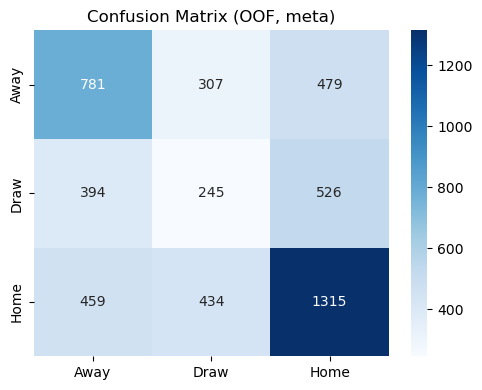

,IV_max,mono_atIV
feature,,
elo_A,0.6740,0.3572
elo_diff,0.6740,-0.3572
elo_H,0.6740,-0.3572
rf_H,0.4314,-0.2262
rf_A,0.4261,0.2433
p3_home_ppg_diff,0.4042,-0.2631
ppg10_diff,0.4002,0.2951
p3_gdpm_diff,0.3997,-0.2630
p3_ppg_diff,0.3821,-0.2636



[Meta] MD2 predictions:


,date,home,away,P_home,P_draw,P_away,Pick,PickTeam
10,2025-08-22,West Ham United,Chelsea,0.179577,0.145944,0.674479,Away,Chelsea
11,2025-08-23,AFC Bournemouth,Wolverhampton Wanderers,0.485085,0.354340,0.160575,Home,AFC Bournemouth
12,2025-08-23,Arsenal,Leeds United,0.837847,0.080088,0.082065,Home,Arsenal
13,2025-08-23,Brentford,Aston Villa,0.311673,0.279081,0.409246,Away,Aston Villa
14,2025-08-23,Burnley,Sunderland,0.495343,0.269757,0.234900,Home,Burnley
15,2025-08-23,Manchester City,Tottenham Hotspur,0.658524,0.163167,0.178309,Home,Manchester City
16,2025-08-24,Crystal Palace,Nottingham Forest,0.367092,0.375354,0.257554,Home,Crystal Palace
17,2025-08-24,Everton,Brighton and Hove Albion,0.265909,0.281864,0.452227,Away,Brighton and Hove Albion
18,2025-08-24,Fulham,Manchester United,0.168028,0.300959,0.531013,Away,Manchester United
19,2025-08-25,Newcastle United,Liverpool,0.160162,0.140901,0.698937,Away,Liverpool



[Meta] MD2 accuracy on finished matches: 0.500 (n=10)


,date,home,away,P_home,P_draw,P_away,Pick,PickTeam,Actual,Correct
0,2025-08-22,West Ham United,Chelsea,0.179577,0.145944,0.674479,Away,Chelsea,Away,1.0
1,2025-08-23,AFC Bournemouth,Wolverhampton Wanderers,0.485085,0.354340,0.160575,Home,AFC Bournemouth,Home,1.0
2,2025-08-23,Arsenal,Leeds United,0.837847,0.080088,0.082065,Home,Arsenal,Home,1.0
3,2025-08-23,Brentford,Aston Villa,0.311673,0.279081,0.409246,Away,Aston Villa,Home,0.0
4,2025-08-23,Burnley,Sunderland,0.495343,0.269757,0.234900,Home,Burnley,Home,1.0
5,2025-08-23,Manchester City,Tottenham Hotspur,0.658524,0.163167,0.178309,Home,Manchester City,Away,0.0
6,2025-08-24,Crystal Palace,Nottingham Forest,0.367092,0.375354,0.257554,Home,Crystal Palace,Draw,0.0
7,2025-08-24,Everton,Brighton and Hove Albion,0.265909,0.281864,0.452227,Away,Brighton and Hove Albion,Home,0.0
8,2025-08-24,Fulham,Manchester United,0.168028,0.300959,0.531013,Away,Manchester United,Draw,0.0
9,2025-08-25,Newcastle United,Liverpool,0.160162,0.140901,0.698937,Away,Liverpool,Away,1.0



=== Projected Table at MD38 (meta-ensemble; rounded to full 38) ===


,ExpPos,Team,Pts_pred_round,W_pred_round,D_pred_round,L_pred_round,Pts_pred,W_pred,D_pred,L_pred
0,1,Liverpool,81,25,6,7,81.586360,25.211059,5.953183,6.835758
1,2,Arsenal,76,23,7,8,76.647419,23.277515,6.814874,7.907611
2,3,Manchester City,70,21,7,10,70.458696,21.301879,6.553059,10.145062
3,4,Chelsea,64,18,10,10,63.071620,17.800888,9.668958,10.530155
4,5,Newcastle United,64,18,10,10,63.137955,17.617148,10.286511,10.096341
5,6,Brighton and Hove Albion,57,16,9,13,56.603760,15.721602,9.438955,12.839444
6,7,Crystal Palace,56,15,11,12,56.289466,15.141212,10.865829,11.992958
7,8,Aston Villa,55,15,10,13,53.761437,14.694533,9.677838,13.627629
8,9,Tottenham Hotspur,54,15,9,14,54.270905,14.985262,9.315118,13.699620
9,10,AFC Bournemouth,54,15,9,14,53.269851,14.695192,9.184276,14.120533



Champion pick: Liverpool


In [14]:
# utilities 
def _canon(t: str) -> str:
    return normalize_team(t)

def _to_eur_any(s) -> float:
    if s is None or (isinstance(s,float) and np.isnan(s)): return np.nan
    txt = str(s).strip().replace("€","").replace(" ","").lower()
    m = re.match(r"([0-9][0-9.,]*)\s*([mbk]n?)?$", txt)
    if not m:
        try: return float(txt.replace(",",""))
        except: return np.nan
    num = m.group(1).replace(",",""); unit = (m.group(2) or "")
    mult = 1.0
    if unit.startswith("b"): mult=1_000_000_000.0
    elif unit.startswith("m"): mult=1_000_000.0
    elif unit.startswith("k"): mult=1_000.0
    try: return float(num)*mult
    except: return np.nan

def _elo_probs_pair(r_h: float, r_a: float, draw_param: float = 0.24):
    dR=r_h-r_a; pH_nd=1.0/(1.0+10**(-dR/400.0)); pA_nd=1.0-pH_nd
    pD=draw_param*np.sqrt(pH_nd*pA_nd); z=1.0+pD
    return np.array([pA_nd/z, pD/z, pH_nd/z])

def _apply_draw_temperature(P, target_draw=0.24):
    base=P.copy(); best=1e9; bestQ=base
    for a in np.linspace(0.6,1.4,17):
        Q=base.copy(); Q[:,1]=np.clip(Q[:,1]**a,1e-9,1-1e-9); Q/=Q.sum(1,keepdims=True)
        err=abs(Q[:,1].mean()-target_draw)
        if err<best: bestQ=Q; best=err
    return bestQ

def scan_csvs():
    roots=[Path("."), Path("data_cache")]
    out=set()
    for r in roots:
        if r.exists():
            for p in r.glob("*.csv"):
                out.add(str(p.resolve()))
    return sorted(out)

csv_files=scan_csvs()
print("CSV sources (deduped):")
for s in csv_files: print(" •", s)
print("\nTotal CSVs discovered:", len(csv_files))

# priors (robust) 
def _load_mv_by_club():
    matches=[p for p in csv_files if p.endswith("tm_market_values_clubs.csv")]
    if not matches: return {}
    df=pd.read_csv(matches[0])
    c_team=next((c for c in df.columns if "club" in c.lower() or "team" in c.lower()), None)
    c_curr=next((c for c in df.columns if "current" in c.lower() and "value" in c.lower()), None)
    if c_curr is None:
        cand=[c for c in df.columns if "value" in c.lower()]
        c_curr=cand[-1] if cand else df.columns[-1]
    out={}
    for _,r in df.iterrows():
        t=_canon(str(r[c_team])); v=_to_eur_any(r[c_curr])
        if t: out[t]=float(v) if pd.notna(v) else np.nan
    return out

def _load_mv_players_sum():
    matches=[p for p in csv_files if p.endswith("tm_market_values_players.csv")]
    if not matches: return {}
    df=pd.read_csv(matches[0])
    if "Club" not in df.columns: return {}
    vals = df["ValueEUR"].apply(_to_eur_any) if df["ValueEUR"].dtype==object else df["ValueEUR"]
    g=pd.DataFrame({"Club":df["Club"],"_val":vals}).groupby("Club",as_index=False)["_val"].sum()
    return {_canon(r["Club"]): float(r["_val"]) for _,r in g.iterrows()}

def _load_pl_managers_tenure():
    matches=[p for p in csv_files if p.endswith("pl_managers_2025_26.csv")]
    if not matches: return {}
    df=pd.read_csv(matches[0])
    return {_canon(str(r.get("Team",""))): float(r.get("TenureDays", np.nan)) for _,r in df.iterrows()}

def _load_jt_ppm_rank():
    matches=[p for p in csv_files if p.endswith("tm_jahrestabelle.csv")]
    if not matches: return {},{}
    df=pd.read_csv(matches[0])
    if "Team" not in df.columns: return {},{}
    if {"Matches","Pts"} <= set(df.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            ppm=df["Pts"].astype(float)/df["Matches"].replace(0,np.nan).astype(float)
    else:
        ppm=pd.Series([np.nan]*len(df))
    P,R={},{}
    for i,r in df.iterrows():
        t=_canon(str(r["Team"])); P[t]=float(ppm.iloc[i]) if pd.notna(ppm.iloc[i]) else np.nan
        R[t]=float(r.get("Rank", np.nan))
    return P,R

def _load_transfers():
    out_net, out_act = {}, {}
    matches=[p for p in csv_files if p.endswith("transfers.csv")]
    if not matches: return out_net, out_act
    df=pd.read_csv(matches[0])
    c_team=next((c for c in df.columns if re.search(r"(club|team)", c, re.I)), None)
    if c_team is None: return out_net, out_act
    name_has = lambda pat: next((c for c in df.columns if re.search(pat, c, re.I)), None)
    c_out = name_has(r"(expend|spent|purchase|out\b).*") or name_has(r"^out(?!.*count)")
    c_in  = name_has(r"(income|sale|sold|in\b).*")      or name_has(r"^in(?!.*count)")
    # counts (optional)
    c_arr = name_has(r"(arrival|in_count|\bin\b.*count)")
    c_dep = name_has(r"(depart|out_count|\bout\b.*count)")
    # fallback money-like
    if c_out is None or c_in is None:
        money_like=[]
        for c in df.columns:
            if c==c_team: continue
            s=df[c].astype(str)
            score = (s.str.contains("€",na=False).mean()*2 + s.str.contains(",",na=False).mean())
            if score>0.1: money_like.append((score,c))
        money_like=sorted(money_like, reverse=True)[:3]
        cols=[c for _,c in money_like]
        if (c_out is None) and cols: c_out=cols[0]
        if (c_in  is None) and len(cols)>1: c_in=cols[1]
    for _,r in df.iterrows():
        t=_canon(str(r[c_team]))
        out_amt = _to_eur_any(r[c_out]) if (c_out is not None and c_out in df.columns) else 0.0
        in_amt  = _to_eur_any(r[c_in])  if (c_in  is not None and c_in  in df.columns) else 0.0
        net = (out_amt or 0.0) - (in_amt or 0.0)     # positive = profit, negative = spend
        arr = float(r.get(c_arr, np.nan)) if (c_arr is not None and c_arr in df.columns) else np.nan
        dep = float(r.get(c_dep, np.nan)) if (c_dep is not None and c_dep in df.columns) else np.nan
        out_net[t]=net; out_act[t]=(arr, dep)
    return out_net, out_act

def _last3_season_priors():
    paths=[p for p in csv_files if re.search(r"E0_\d{4}\.csv$", p)]
    paths=sorted(paths)[-3:]
    if not paths: return {},{}, {},{}
    frames=[]
    for p in paths:
        try:
            df=pd.read_csv(p).dropna(subset=["FTR","FTHG","FTAG"])
            frames.append(df[["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]])
        except: pass
    if not frames: return {},{},{},{}
    hist=pd.concat(frames, ignore_index=True)
    rows=[]
    for _,r in hist.iterrows():
        h,a=_canon(r["HomeTeam"]),_canon(r["AwayTeam"]); hg,ag=int(r["FTHG"]),int(r["FTAG"])
        if r["FTR"]=="H":
            rows+=[{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag},
                   {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg}]
        elif r["FTR"]=="A":
            rows+=[{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag},
                   {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg}]
        else:
            rows+=[{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag},
                   {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg}]
    tab=pd.DataFrame(rows).groupby("Team",as_index=False).sum(numeric_only=True)
    tab["PPM"]=(3*tab["W"]+tab["D"])/tab["Pl"].replace(0,np.nan)
    tab["GDPM"]=(tab["GF"]-tab["GA"])/tab["Pl"].replace(0,np.nan)
    PPM=dict(zip(tab["Team"],tab["PPM"])); GDPM=dict(zip(tab["Team"],tab["GDPM"]))
    H=hist.assign(Team=hist["HomeTeam"].map(_canon),
                  pts=np.select([(hist["FTR"]=="H"),(hist["FTR"]=="D")],[3,1],0))
    A=hist.assign(Team=hist["AwayTeam"].map(_canon),
                  pts=np.select([(hist["FTR"]=="A"),(hist["FTR"]=="D")],[3,1],0))
    HPPM=(H.groupby("Team")["pts"].sum()/H.groupby("Team")["pts"].count()).to_dict()
    APPM=(A.groupby("Team")["pts"].sum()/A.groupby("Team")["pts"].count()).to_dict()
    return PPM, GDPM, HPPM, APPM

def _load_md1_snapshot():
    """
    New file: pl_md1_until_blank.csv
    Expect at least Team + Pts/PPG/GD… If unknown, compute what we can.
    We'll only use this for MD3+; for MD2 inference we will **not** feed these features.
    """
    matches=[p for p in csv_files if p.endswith("pl_md1_until_blank.csv")]
    if not matches: return {}
    df=pd.read_csv(matches[0])
    # try to normalize a basic snapshot metric per team (PPG or Pts)
    c_team=next((c for c in df.columns if re.search(r"team", c, re.I)), None)
    if c_team is None: return {}
    # prefer PPG; else derive from Pts/Pl
    c_ppg=next((c for c in df.columns if re.search(r"\bppg\b", c, re.I)), None)
    if c_ppg is None:
        c_pts=next((c for c in df.columns if re.search(r"\bpts?\b", c, re.I)), None)
        c_pl =next((c for c in df.columns if re.search(r"\bpl(ayed)?\b", c, re.I)), None)
        if c_pts and c_pl:
            with np.errstate(divide="ignore", invalid="ignore"):
                df["_PPG"]=pd.to_numeric(df[c_pts], errors="coerce")/pd.to_numeric(df[c_pl], errors="coerce").replace(0,np.nan)
            c_ppg="_PPG"
        else:
            return {}
    snap={}
    for _,r in df.iterrows():
        t=_canon(str(r[c_team])); v=pd.to_numeric(r[c_ppg], errors="coerce")
        if t and pd.notna(v): snap[t]=float(v)
    return snap

# load priors + medians
MV_CLUB=_load_mv_by_club()
MVP_SUM=_load_mv_players_sum()
MAN_TEN=_load_pl_managers_tenure()
JT_PPM, JT_RNK=_load_jt_ppm_rank()
TR_NET, TR_ACT=_load_transfers()
P3_PPM, P3_GDPM, P3_HPPM, P3_APPM=_last3_season_priors()
MD1_SNAP=_load_md1_snapshot()     # <-- new snapshot (MD1 only; ignore for MD2 inference)

_med=lambda d, dflt=0.0: float(np.median([v for v in d.values() if pd.notna(v)])) if d else float(dflt)
MV_MED=_med(MV_CLUB,3e8); MVP_MED=_med(MVP_SUM,2e8); TEN_MED=_med(MAN_TEN,365.0)
JPPM_MD=_med(JT_PPM,1.5); JRNK_MD=_med(JT_RNK,10.0); NET_MD=_med(TR_NET,0.0)
P3P_MD=_med(P3_PPM,1.4); P3G_MD=_med(P3_GDPM,0.0); HPP_MD=_med(P3_HPPM,1.6); APP_MD=_med(P3_APPM,1.1)
MD1_MD =_med(MD1_SNAP,1.5)

# training meta frame 
base=MODEL_BUNDLE["train_df"].copy()
y   =MODEL_BUNDLE["y"].astype(int).values
P_rf=MODEL_BUNDLE["oof_proba"].copy()
P_elo=np.vstack([_elo_probs_pair(h,a) for h,a in zip(base["EloHome_pre"], base["EloAway_pre"])])

def _roll_side(df, side, w):
    if side=="H":
        t=df[["Date","HomeTeam","FTR","FTHG","FTAG"]].rename(columns={"HomeTeam":"Team","FTHG":"GF","FTAG":"GA"})
        win=(df["FTR"]=="H").astype(int); draw=(df["FTR"]=="D").astype(int)
    else:
        t=df[["Date","AwayTeam","FTR","FTHG","FTAG"]].rename(columns={"AwayTeam":"Team","FTAG":"GF","FTHG":"GA"})
        win=(df["FTR"]=="A").astype(int); draw=(df["FTR"]=="D").astype(int)
    t=t.assign(pts=3*win+draw, gd=lambda x:x["GF"]-x["GA"], cs=(t["GA"]==0).astype(int), btts=((t["GF"]>0)&(t["GA"]>0)).astype(int))
    t=t.sort_values(["Team","Date"]).copy()
    R=lambda s: s.shift(1).rolling(w, min_periods=1).sum()
    return pd.DataFrame({"Team":t["Team"],"Date":t["Date"],
                         f"ppg{w}":R(t["pts"])/w, f"gd{w}":R(t["gd"]),
                         f"cs{w}":R(t["cs"]), f"btts{w}":R(t["btts"])})

def _attach_rich(df):
    H5=_roll_side(df,"H",5); H10=_roll_side(df,"H",10)
    A5=_roll_side(df,"A",5); A10=_roll_side(df,"A",10)
    out=df.merge(H5.add_prefix("H_"), left_on=["HomeTeam","Date"], right_on=["H_Team","H_Date"], how="left") \
          .merge(H10.add_prefix("H10_"), left_on=["HomeTeam","Date"], right_on=["H10_Team","H10_Date"], how="left") \
          .merge(A5.add_prefix("A_"), left_on=["AwayTeam","Date"], right_on=["A_Team","A_Date"], how="left") \
          .merge(A10.add_prefix("A10_"), left_on=["AwayTeam","Date"], right_on=["A10_Team","A10_Date"], how="left")
    for c in ["H_ppg5","H_gd5","H_cs5","H_btts5","H10_ppg10","H10_gd10",
              "A_ppg5","A_gd5","A_cs5","A_btts5","A10_ppg10","A10_gd10"]:
        if c not in out.columns: out[c]=np.nan
    out=out.rename(columns={"H10_ppg10":"H_ppg10","H10_gd10":"H_gd10",
                            "A10_ppg10":"A_ppg10","A10_gd10":"A_gd10"})
    return out[["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG",
                "H_ppg5","H_gd5","H_cs5","H_btts5","H_ppg10","H_gd10",
                "A_ppg5","A_gd5","A_cs5","A_btts5","A_ppg10","A_gd10"]]

rich=_attach_rich(base)
home=base["HomeTeam"].map(_canon); away=base["AwayTeam"].map(_canon)

# promoted flags (vs 24/25 squads)
try:
    prev=pd.read_csv([p for p in csv_files if p.endswith("E0_2425.csv")][0])
    teams_prev=set(_canon(t) for t in pd.unique(pd.concat([prev["HomeTeam"], prev["AwayTeam"]]).dropna()))
except:
    teams_prev=set(_canon(t) for t in pd.unique(pd.concat([home, away]).dropna()))
prom_h=~home.isin(teams_prev); prom_a=~away.isin(teams_prev)

def _diff(h,a,M,med): 
    return h.map(lambda t:M.get(t,med)).astype(float) - a.map(lambda t:M.get(t,med)).astype(float)

# MD1 snapshot prior (for train rows that chronologically occur after MD1 of a given season)
MD1_PRIOR_H = home.map(lambda t: MD1_SNAP.get(t, MD1_MD)).astype(float)
MD1_PRIOR_A = away.map(lambda t: MD1_SNAP.get(t, MD1_MD)).astype(float)

meta_df=pd.DataFrame({
    "elo_diff": base["EloHome_pre"]-base["EloAway_pre"],
    "form_ppg_diff": base["H_Last5_PPG"]-base["A_Last5_PPG"],
    "ppg5_diff": (rich["H_ppg5"]-rich["A_ppg5"]).fillna(0.0),
    "ppg10_diff": (rich["H_ppg10"]-rich["A_ppg10"]).fillna(0.0),
    "gd5_diff": (rich["H_gd5"]-rich["A_gd5"]).fillna(0.0),
    "btts5_diff": (rich["H_btts5"]-rich["A_btts5"]).fillna(0.0),
    "mv_diff": (_diff(home,away,MV_CLUB,MV_MED)).apply(np.log1p),
    "mvp_diff": (_diff(home,away,MVP_SUM,MVP_MED)).apply(np.log1p),
    "ten_diff": _diff(home,away,MAN_TEN,TEN_MED),
    "jahr_ppm_diff": _diff(home,away,JT_PPM,JPPM_MD),
    "rank_diff": _diff(away,home,JT_RNK,JRNK_MD),
    "netspend_diff": _diff(home,away,TR_NET,NET_MD),
    "p3_ppg_diff": _diff(home,away,P3_PPM,P3P_MD),
    "p3_gdpm_diff": _diff(home,away,P3_GDPM,P3G_MD),
    "p3_home_ppg_diff": _diff(home,away,P3_HPPM,HPP_MD),
    # MD1 snapshot priors (will be ignored for MD2 inference below, but kept for later weeks):
    "md1_ppg_diff": (MD1_PRIOR_H - MD1_PRIOR_A),
    "h2h_home": base["H2H_H_win_rate"].fillna(0.33),
    "h2h_draw": base["H2H_draw_rate"].fillna(0.33),
    "rest_diff": base["RestH"]-base["RestA"],
    "prom_h": prom_h.astype(int), "prom_a": prom_a.astype(int),
    "rf_A": P_rf[:,0], "rf_D": P_rf[:,1], "rf_H": P_rf[:,2],
    "elo_A": P_elo[:,0], "elo_D": P_elo[:,1], "elo_H": P_elo[:,2],
})

META_FEATS=list(meta_df.columns)
META_MED = meta_df.median(axis=0).to_dict()
def _align_meta(X):
    X = pd.DataFrame({c: X[c] if c in X.columns else META_MED[c] for c in META_FEATS})
    return X[META_FEATS].fillna(pd.Series(META_MED))

# OOF training 
tscv=TimeSeriesSplit(n_splits=5)
oof=np.zeros((len(meta_df),3)); rows=[]
for k,(tr,va) in enumerate(tscv.split(meta_df), start=1):
    Xtr=_align_meta(meta_df.iloc[tr]); Xva=_align_meta(meta_df.iloc[va]); ytr,yva=y[tr],y[va]
    lr=make_pipeline(SimpleImputer(strategy="median"),
                     StandardScaler(with_mean=True, with_std=True),
                     LogisticRegression(max_iter=2200, multi_class="multinomial",
                                        C=2.2, class_weight="balanced", n_jobs=-1))
    lr.fit(Xtr,ytr); P_lr=lr.predict_proba(Xva)
    hgb=HistGradientBoostingClassifier(learning_rate=0.085, max_depth=6, max_iter=420,
                                       l2_regularization=0.3, max_bins=255, random_state=k)
    hgb.fit(Xtr,ytr); P_hgb=hgb.predict_proba(Xva)
    P=(0.55*P_lr+0.45*P_hgb); oof[va]=P
    rows.append({"fold":k,"acc":accuracy_score(yva,np.argmax(P,axis=1)),
                 "macro_f1":f1_score(yva,np.argmax(P,axis=1),average="macro")})
cv=pd.DataFrame(rows); print(cv.round(4))
print(f"\nMeans → Acc: {cv['acc'].mean():.4f}  MacroF1: {cv['macro_f1'].mean():.4f}")

P_meta=_apply_draw_temperature(oof, 0.24)

def _best_tau(P, y_true, grid=np.linspace(0.30,0.52,15)):
    best=-1; best_tau=0.35
    for t in grid:
        picks=np.where(P[:,1]>=t, 1, np.argmax(P[:,[0,2]],axis=1)*2)
        acc=accuracy_score(y_true,picks)
        if acc>best: best=acc; best_tau=t
    return best_tau
TAU_DRAW=_best_tau(P_meta, y)

picks_oof=np.where(P_meta[:,1]>=TAU_DRAW, 1, np.where(P_meta[:,2]>=P_meta[:,0], 2, 0))
print("\nClassification report (OOF, meta):")
print(classification_report(y, picks_oof, target_names=["Away","Draw","Home"]))
print("Accuracy:", f"{accuracy_score(y, picks_oof):.4f}")
print("Macro F1:", f"{f1_score(y, picks_oof, average='macro'):.4f}")
print("AUC (OvR):", f"{roc_auc_score(y, P_meta, multi_class='ovr'):.4f}")

cm=confusion_matrix(y,picks_oof,labels=[0,1,2])
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Away","Draw","Home"], yticklabels=["Away","Draw","Home"])
plt.title("Confusion Matrix (OOF, meta)"); plt.tight_layout(); plt.show()

#  IV + monotonicity 
def _iv_one(x, y_bin, n_bins=10):
    s=pd.Series(x).replace([np.inf,-np.inf], np.nan)
    if s.notna().sum()<2: return np.nan,np.nan
    bins=pd.qcut(s.rank(method="first"), q=min(n_bins, s.notna().sum()), duplicates="drop")
    df=pd.DataFrame({"bin":bins, "y":y_bin}).dropna()
    if df.empty or df["bin"].nunique()<2: return np.nan,np.nan
    tab=df.groupby("bin")["y"].agg(["sum","count"]).rename(columns={"sum":"event"})
    tab["non_event"]=tab["count"]-tab["event"]
    tab["p_event"]    =(tab["event"]/tab["event"].sum()).replace(0,1e-9)
    tab["p_non_event"]=(tab["non_event"]/tab["non_event"].sum()).replace(0,1e-9)
    woe=np.log(tab["p_event"]/tab["p_non_event"]); iv=((tab["p_event"]-tab["p_non_event"])*woe).sum()
    mono=df["y"].corr(df["bin"].cat.codes, method="spearman")
    return float(iv), float(mono)

def compute_iv_table(X, y, classes=(0,1,2)):
    outs=[]
    for c in classes:
        yb=(y==c).astype(int); rows=[]
        for col in X.columns:
            iv,mono=_iv_one(X[col], yb); rows.append((col,iv,mono))
        outs.append(pd.DataFrame(rows, columns=["feature",f"IV_{c}",f"mono_{c}"]).set_index("feature"))
    M=pd.concat(outs, axis=1)
    M["IV_max"]=M[[f"IV_{c}" for c in classes]].max(axis=1)
    M["mono_atIV"]=M.apply(lambda r: r[[f"mono_{c}" for c in classes]][np.argmax([r[f"IV_{c}"] for c in classes])], axis=1)
    return M.sort_values("IV_max", ascending=False)

iv_tbl=compute_iv_table(_align_meta(meta_df), y)
print()
display(iv_tbl[["IV_max","mono_atIV"]].head(20).round(4))

#  fit final ensemble 
X_all=_align_meta(meta_df)
LR_final=make_pipeline(SimpleImputer(strategy="median"),
                       StandardScaler(with_mean=True, with_std=True),
                       LogisticRegression(max_iter=2200, multi_class="multinomial",
                                          C=2.2, class_weight="balanced", n_jobs=-1))
LR_final.fit(X_all, y)
HGB_final=HistGradientBoostingClassifier(learning_rate=0.085, max_depth=6, max_iter=420,
                                         l2_regularization=0.3, max_bins=255, random_state=0)
HGB_final.fit(X_all, y)

def _predict_meta(X):
    X=_align_meta(X)
    return 0.55*LR_final.predict_proba(X) + 0.45*HGB_final.predict_proba(X)

#  history utils 
fx=pd.read_csv([p for p in csv_files if p.endswith("fixtures_2025_26.csv")][0])
fx["date"]=pd.to_datetime(fx["date"], errors="coerce")
if "played" not in fx.columns: fx["played"]=fx["FTR"].notna()

hist=MODEL_BUNDLE["train_df"][["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]].dropna(subset=["FTR"]).copy()
played=fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam","date":"Date"})
if not played.empty: hist=pd.concat([hist,played[["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]], ignore_index=True)
hist=hist.sort_values("Date").reset_index(drop=True)

def _elo_now_from_history(history):
    teams=pd.unique(pd.concat([history["HomeTeam"],history["AwayTeam"]]))
    R={t:1500.0 for t in teams}
    for _,r in history.sort_values("Date").iterrows():
        ra,rb=R[r["HomeTeam"]],R[r["AwayTeam"]]
        score_h=1.0 if r["FTR"]=="H" else (0.5 if r["FTR"]=="D" else 0.0)
        try: gd=int(abs(float(r["FTHG"])-float(r["FTAG"])))
        except: gd=None
        new_h,new_a=elo_update(ra,rb,score_h,k=20.0,home_adv=60.0,is_home_a=True,goal_diff=gd)
        R[r["HomeTeam"]],R[r["AwayTeam"]]=new_h,new_a
    return R

def _last5_side(history, team, side, asof, n=5):
    h=history[history["Date"]<asof]
    if side=="H":
        h=h[h["HomeTeam"]==team].sort_values("Date").tail(n)
        if h.empty: return {"rGF":0.0,"rGA":0.0,"PPG":0.0}
        GF=h["FTHG"].astype(float).values; GA=h["FTAG"].astype(float).values
        W=(h["FTR"]=="H").astype(float).values; D=(h["FTR"]=="D").astype(float).values
    else:
        h=h[h["AwayTeam"]==team].sort_values("Date").tail(n)
        if h.empty: return {"rGF":0.0,"rGA":0.0,"PPG":0.0}
        GF=h["FTAG"].astype(float).values; GA=h["FTHG"].astype(float).values
        W=(h["FTR"]=="A").astype(float).values; D=(h["FTR"]=="D").astype(float).values
    m=len(GF); return {"rGF":GF.mean(),"rGA":GA.mean(),"PPG":(3*W.sum()+D.sum())/m}

def _h2h_asof(history, home, away, asof, n=5):
    h=history[((history["HomeTeam"]==home)&(history["AwayTeam"]==away))|
              ((history["HomeTeam"]==away)&(history["AwayTeam"]==home))]
    h=h[h["Date"]<asof].sort_values("Date").tail(n)
    if h.empty: return (0.33,0.33,0.34)
    hW=((h["HomeTeam"]==home)&(h["FTR"]=="H")).sum()+((h["AwayTeam"]==home)&(h["FTR"]=="A")).sum()
    aW=((h["HomeTeam"]==away)&(h["FTR"]=="H")).sum()+((h["AwayTeam"]==away)&(h["FTR"]=="A")).sum()
    dr=(h["FTR"]=="D").sum(); tot=len(h)
    return (hW/tot, aW/tot, dr/tot)

# meta features for a fixture list 
def _build_meta_for_matches(fixt, hist_all, use_md1_snapshot=True, ignore_md2_extra=True):
    R=_elo_now_from_history(hist_all); rows=[]
    for _,m in fixt.iterrows():
        d=pd.to_datetime(m["date"]); h=_canon(m["home"]); a=_canon(m["away"])
        H5=_last5_side(hist_all,h,"H",d,5); A5=_last5_side(hist_all,a,"A",d,5)
        h2hH,_,h2hD=_h2h_asof(hist_all,h,a,d,5)
        mv_d  = np.log1p(MV_CLUB.get(h,MV_MED))-np.log1p(MV_CLUB.get(a,MV_MED))
        mvp_d = np.log1p(MVP_SUM.get(h,MVP_MED))-np.log1p(MVP_SUM.get(a,MVP_MED))
        md1_d = 0.0
        if use_md1_snapshot:
            md1_d = (MD1_SNAP.get(h,MD1_MD)-MD1_SNAP.get(a,MD1_MD))
        # for MD2 specifically, keep md1_d but avoid any MD2-derived stats (we don't create them here anyway)
        row={
            "elo_diff": R.get(h,1500.0)-R.get(a,1500.0),
            "form_ppg_diff": H5["PPG"]-A5["PPG"],
            "ppg5_diff": H5["PPG"]-A5["PPG"], "ppg10_diff": 0.0,
            "gd5_diff": (H5["rGF"]-H5["rGA"])-(A5["rGF"]-A5["rGA"]),
            "btts5_diff": 0.0,
            "mv_diff": mv_d, "mvp_diff": mvp_d,
            "ten_diff": MAN_TEN.get(h,TEN_MED)-MAN_TEN.get(a,TEN_MED),
            "jahr_ppm_diff": JT_PPM.get(h,JPPM_MD)-JT_PPM.get(a,JPPM_MD),
            "rank_diff": JT_RNK.get(a,JRNK_MD)-JT_RNK.get(h,JRNK_MD),
            "netspend_diff": TR_NET.get(h,NET_MD)-TR_NET.get(a,NET_MD),
            "p3_ppg_diff": P3_PPM.get(h,P3P_MD)-P3_PPM.get(a,P3P_MD),
            "p3_gdpm_diff": P3_GDPM.get(h,P3G_MD)-P3_GDPM.get(a,P3G_MD),
            "p3_home_ppg_diff": P3_HPPM.get(h,HPP_MD)-P3_HPPM.get(a,HPP_MD),
            "md1_ppg_diff": md1_d,
            "h2h_home": h2hH, "h2h_draw": h2hD, "rest_diff": 0.0,
            "prom_h": int(h not in teams_prev), "prom_a": int(a not in teams_prev),
        }
        # RF/Elo base inputs (always available)
        FEATS=MODEL_BUNDLE["feat_cols"]
        stub=pd.DataFrame(0.0, index=[0], columns=FEATS)
        minimal={"EloHome_pre":R.get(h,1500.0),"EloAway_pre":R.get(a,1500.0),
                 "H_Last5_PPG":H5["PPG"], "A_Last5_PPG":A5["PPG"],
                 "H2H_H_win_rate":h2hH, "H2H_draw_rate":h2hD}
        for c,v in minimal.items():
            if c in stub.columns: stub.at[0,c]=float(v)
        P_base=MODEL_BUNDLE["model"].predict_proba(stub.values)[0]
        row.update({"rf_A":P_base[0],"rf_D":P_base[1],"rf_H":P_base[2]})
        pA,pD,pH=_elo_probs_pair(R.get(h,1500.0), R.get(a,1500.0))
        row.update({"elo_A":pA,"elo_D":pD,"elo_H":pH})
        rows.append(row)
    return _align_meta(pd.DataFrame(rows))

# MD2 inference (uses MD1 snapshot only; no MD2 leakage) 
md2=fx[fx["md"]==2][["date","home","away","FTR","FTHG","FTAG","played"]].copy()
md2["home"]=md2["home"].map(_canon); md2["away"]=md2["away"].map(_canon)
X_md2=_build_meta_for_matches(md2[["date","home","away"]], hist, use_md1_snapshot=True, ignore_md2_extra=True)
P_md2=_apply_draw_temperature(_predict_meta(X_md2), 0.24)
md2_pick=np.where(P_md2[:,1]>=TAU_DRAW, "Draw", np.where(P_md2[:,2]>=P_md2[:,0], "Home", "Away"))
md2_out=md2[["date","home","away"]].copy()
md2_out["P_home"]=P_md2[:,2]; md2_out["P_draw"]=P_md2[:,1]; md2_out["P_away"]=P_md2[:,0]
md2_out["Pick"]=md2_pick
md2_out["PickTeam"]=np.where(md2_out["Pick"]=="Home", md2_out["home"],
                      np.where(md2_out["Pick"]=="Away", md2_out["away"], "—"))
print("\n[Meta] MD2 predictions:"); display(md2_out.sort_values("date"))

done=md2[md2["played"]]
if not done.empty:
    done_eval=done.merge(md2_out, on=["date","home","away"])
    done_eval["Actual"]=done_eval["FTR"].map({"H":"Home","D":"Draw","A":"Away"})
    done_eval["Correct"]=(done_eval["Actual"]==done_eval["Pick"]).astype(float)
    print(f"\n[Meta] MD2 accuracy on finished matches: {done_eval['Correct'].mean():.3f} (n={len(done_eval)})")
    display(done_eval[["date","home","away","P_home","P_draw","P_away","Pick","PickTeam","Actual","Correct"]]
            .sort_values("date"))

# MD38 projection with exact-38 rounding 
def _expected_points_block(scored):
    teams=pd.unique(pd.concat([scored["home"], scored["away"]]).map(_canon))
    agg={t:{"ExpPts":0.0,"expW":0.0,"expD":0.0,"expL":0.0} for t in teams}
    for _,r in scored.iterrows():
        h,a=_canon(r["home"]),_canon(r["away"])
        ph,pd_,pa=float(r["P_home"]),float(r["P_draw"]),float(r["P_away"])
        agg[h]["ExpPts"]+=3*ph+pd_; agg[a]["ExpPts"]+=3*pa+pd_
        agg[h]["expW"]  += ph; agg[h]["expD"] += pd_; agg[h]["expL"] += pa
        agg[a]["expW"]  += pa; agg[a]["expD"] += pd_; agg[a]["expL"] += ph
    return pd.DataFrame([{"Team":t, **v} for t,v in agg.items()])

def _round_season(W,D,L,games=38):
    W=np.asarray(W); D=np.asarray(D); L=np.asarray(L)
    n=len(W); RW=np.zeros(n,dtype=int); RD=np.zeros(n,dtype=int); RL=np.zeros(n,dtype=int)
    for i in range(n):
        w,d,l=float(W[i]),float(D[i]),float(L[i])
        wf,df,lf=int(np.floor(w)),int(np.floor(d)),int(np.floor(l))
        res=[w-wf, d-df, l-lf]; tot=wf+df+lf; need=int(games-tot)
        if need>0:
            for _ in range(need):
                j=int(np.argmax(res)); 
                if j==0: wf+=1
                elif j==1: df+=1
                else: lf+=1
                res[j]=-1
        elif need<0:
            for _ in range(-need):
                j=int(np.argmin(res))
                if j==0 and wf>0: wf-=1
                elif j==1 and df>0: df-=1
                elif j==2 and lf>0: lf-=1
                res[j]=1
        RW[i]=wf; RD[i]=df; RL[i]=lf
    return RW,RD,RL

remain=fx[~fx["played"]][["date","home","away"]].copy()
if not remain.empty:
    X_rem=_build_meta_for_matches(remain, hist, use_md1_snapshot=True, ignore_md2_extra=True)
    P_rem=_apply_draw_temperature(_predict_meta(X_rem), 0.24)
    scored=pd.DataFrame({"home":remain["home"], "away":remain["away"],
                         "P_home":P_rem[:,2], "P_draw":P_rem[:,1], "P_away":P_rem[:,0]})
    exp=_expected_points_block(scored)

    def _build_table(df):
        if df.empty: return pd.DataFrame(columns=["Pos","Team","Pl","W","D","L","GF","GA","GD","Pts"])
        rows=[]
        for _,r in df.iterrows():
            h,a=r["HomeTeam"],r["AwayTeam"]; hg,ag=int(r["FTHG"]),int(r["FTAG"])
            if r["FTR"]=="H":
                rows+=[{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag},
                       {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg}]
            elif r["FTR"]=="A":
                rows+=[{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag},
                       {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg}]
            else:
                rows+=[{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag},
                       {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg}]
        tab=pd.DataFrame(rows).groupby("Team",as_index=False).sum(numeric_only=True)
        tab["GD"]=tab["GF"]-tab["GA"]; tab["Pts"]=3*tab["W"]+tab["D"]
        tab=tab.sort_values(["Pts","GD","GF"], ascending=[False,False,False]).reset_index(drop=True)
        tab["Pos"]=np.arange(1,len(tab)+1); return tab

    tab_now=_build_table(
        fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam"})
          [["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]
    )

    base_tab = tab_now.copy() if not tab_now.empty else \
               pd.DataFrame({"Team":sorted(set(pd.unique(pd.concat([fx["home"],fx["away"]]).map(_canon)))),
                             "Pl":0,"W":0,"D":0,"L":0,"GF":0,"GA":0,"GD":0,"Pts":0})

    final=base_tab.merge(exp, on="Team", how="left").fillna(0.0)
    W = final["W"]+final["expW"]; D = final["D"]+final["expD"]; L = final["L"]+final["expL"]
    RW,RD,RL=_round_season(W.values, D.values, L.values, games=38)
    final["W_pred_round"]=RW; final["D_pred_round"]=RD; final["L_pred_round"]=RL
    final["Pts_pred_round"]= (3*final["W_pred_round"] + final["D_pred_round"]).astype(int)
    final["Pts_pred"]=final["Pts"]+final["ExpPts"]; final["W_pred"]=W; final["D_pred"]=D; final["L_pred"]=L

    final_table=final.sort_values(["Pts_pred_round","W_pred_round"], ascending=[False,False]).reset_index(drop=True)
    final_table.insert(0,"ExpPos",np.arange(1,len(final_table)+1))
    print("\n=== Projected Table at MD38 (meta-ensemble; rounded to full 38) ===")
    display(final_table[["ExpPos","Team","Pts_pred_round","W_pred_round","D_pred_round","L_pred_round",
                         "Pts_pred","W_pred","D_pred","L_pred"]].head(20))
    print("\nChampion pick:", final_table.iloc[0]["Team"])
else:
    print("\n[Info] No remaining fixtures to project.")


## Calibration & Monte Carlo season simulation

Reads the last 5 seasons to estimate a league **draw rate** and champion points benchmarks, then recalibrates meta probabilities to that draw target.
Runs a Monte Carlo over the remaining fixtures with exact-38 rounding to produce a median MD38 table (points/W-D-L intervals) and **title odds** per club.
Prints a calibration note if the simulated champion’s points look unrealistically low vs. recent seasons.


In [15]:
# read last 5 seasons for calibration (champion points + league draw rate) 
def _lastN_paths(n=5):
    cache = Path("data_cache")
    if not cache.exists(): return []
    E0 = sorted(cache.glob("E0_*.csv"))
    return [str(p) for p in E0][-n:]

def _champion_pts_and_draw_rate(paths):
    champs=[]; draws_all=[]; seasons=[]
    for p in paths:
        try:
            df=pd.read_csv(p)
            df=df.dropna(subset=["FTR","FTHG","FTAG"]).copy()
            # per-season draw share
            draws_all.append((df["FTR"]=="D").mean())
            seasons.append(p)
            # champion points
            rows=[]
            for _,r in df.iterrows():
                h,a=str(r["HomeTeam"]),str(r["AwayTeam"]); hg,ag=int(r["FTHG"]),int(r["FTAG"])
                if r["FTR"]=="H":
                    rows+=[{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag,"Pts":3},
                           {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg,"Pts":0}]
                elif r["FTR"]=="A":
                    rows+=[{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag,"Pts":0},
                           {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg,"Pts":3}]
                else:
                    rows+=[{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag,"Pts":1},
                           {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg,"Pts":1}]
            tab=pd.DataFrame(rows).groupby("Team", as_index=False).sum(numeric_only=True)
            champs.append(int(tab["Pts"].max()))
        except Exception:
            pass
    return champs, draws_all, seasons

paths5=_lastN_paths(5)
champ5, draw5, seas = _champion_pts_and_draw_rate(paths5)
draw_target = float(np.mean(draw5)) if draw5 else 0.24
champ_stats = {"mean": np.mean(champ5) if champ5 else np.nan,
               "median": np.median(champ5) if champ5 else np.nan,
               "p25": np.percentile(champ5,25) if champ5 else np.nan,
               "p75": np.percentile(champ5,75) if champ5 else np.nan}
print(f"[Calib] Last-5 champion pts ~ mean={champ_stats['mean']:.1f} | median={champ_stats['median']:.1f} "
      f"| P25={champ_stats['p25']:.1f} | P75={champ_stats['p75']:.1f}; draw_target≈{draw_target:.3f}")

# recompute meta probabilities for remaining fixtures with calibrated draw target 
remain = fx[~fx["played"]][["date","home","away"]].copy()
if remain.empty:
    print("[Info] No remaining fixtures; Monte Carlo skipped.")
else:
    X_rem_cal = _build_meta_for_matches(remain, hist, use_md1_snapshot=True, ignore_md2_extra=True)
    P_rem_raw = _predict_meta(X_rem_cal)
    P_rem = _apply_draw_temperature(P_rem_raw, target_draw=draw_target)

    #  Monte Carlo simulator over schedule----
    def _tab_now(fx):
        if fx[fx["played"]].empty:
            teams=sorted(set(pd.unique(pd.concat([fx["home"],fx["away"]]).dropna().map(_canon))))
            return pd.DataFrame({"Team":teams,"Pl":0,"W":0,"D":0,"L":0,"GF":0,"GA":0,"GD":0,"Pts":0})
        df=fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam"})
        rows=[]
        for _,r in df.iterrows():
            h,a=r["HomeTeam"],r["AwayTeam"]; hg,ag=int(r["FTHG"]),int(r["FTAG"])
            if r["FTR"]=="H":
                rows+=[{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag,"Pts":3},
                       {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg,"Pts":0}]
            elif r["FTR"]=="A":
                rows+=[{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag,"Pts":0},
                       {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg,"Pts":3}]
            else:
                rows+=[{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag,"Pts":1},
                       {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg,"Pts":1}]
        tab=pd.DataFrame(rows).groupby("Team",as_index=False).sum(numeric_only=True)
        tab["GD"]=tab["GF"]-tab["GA"]
        return tab[["Team","Pl","W","D","L","GF","GA","GD","Pts"]]

    base_tab = _tab_now(fx)

    # helper for 38-match rounding (uses the one you already have)
    def _round_WDL_to_38(w, d, l):
        RW,RD,RL=_round_season(np.array(w), np.array(d), np.array(l), games=38)
        return RW.astype(int), RD.astype(int), RL.astype(int)

    # vector of probabilities for remain matches
    # column order: [Away, Draw, Home]
    pr = P_rem.copy()
    # small numeric guard
    pr = pr / pr.sum(axis=1, keepdims=True)

    # mapping index <> match tuple
    rem_idx = remain.reset_index(drop=True)
    teams = sorted(set(pd.unique(pd.concat([fx["home"],fx["away"]]).dropna().map(_canon))))
    idx_team = {t:i for i,t in enumerate(teams)}
    nT=len(teams); nM=len(rem_idx)

    def simulate_once(rng):
        W=np.zeros(nT); D=np.zeros(nT); L=np.zeros(nT); P=np.zeros(nT)
        GD=np.zeros(nT)
        for i in range(nM):
            h=_canon(rem_idx.loc[i,"home"]); a=_canon(rem_idx.loc[i,"away"])
            ih, ia = idx_team[h], idx_team[a]
            pa, pdw, ph = pr[i,0], pr[i,1], pr[i,2]
            r = rng.random()
            if r < pa:     # Away win
                W[ia]+=1; L[ih]+=1; P[ia]+=3; GD[ia]+=1; GD[ih]-=1
            elif r < pa+pdw: # Draw
                D[ih]+=1; D[ia]+=1; P[ih]+=1; P[ia]+=1
            else:          # Home win
                W[ih]+=1; L[ia]+=1; P[ih]+=3; GD[ih]+=1; GD[ia]-=1
        # add current table
        T=base_tab.set_index("Team").reindex(teams).fillna(0)
        W+=T["W"].values; D+=T["D"].values; L+=T["L"].values; P+=T["Pts"].values; GD+=T["GD"].values
        # round WDL to exactly 38
        RW,RD,RL=_round_WDL_to_38(W,D,L)
        Pts = 3*RW + RD
        return RW,RD,RL,Pts,GD

    # run simulations
    Nsim=3000  # increase if you want tighter estimates
    rng=np.random.default_rng(42)
    W_sims=[]; D_sims=[]; L_sims=[]; PTS_sims=[]; GD_sims=[]
    for s in range(Nsim):
        RW,RD,RL,PT,GDv = simulate_once(rng)
        W_sims.append(RW); D_sims.append(RD); L_sims.append(RL); PTS_sims.append(PT); GD_sims.append(GDv)
    W_sims=np.array(W_sims); D_sims=np.array(D_sims); L_sims=np.array(L_sims)
    PTS_sims=np.array(PTS_sims); GD_sims=np.array(GD_sims)

    # title odds
    champ_counts=np.zeros(nT, dtype=int)
    for s in range(Nsim):
        # rank by points, then GD
        order=np.lexsort((GD_sims[s], PTS_sims[s]))   # ascending
        # top is last
        champ_idx=order[-1]
        champ_counts[champ_idx]+=1
    title_odds=champ_counts/Nsim

    # median season table + 90% interval for points
    med_pts=np.median(PTS_sims, axis=0)
    p10=np.percentile(PTS_sims, 10, axis=0); p90=np.percentile(PTS_sims, 90, axis=0)
    med_W=np.median(W_sims, axis=0); med_D=np.median(D_sims, axis=0); med_L=np.median(L_sims, axis=0)

    sim_tab=pd.DataFrame({
        "Team":teams,
        "Pts_med":med_pts, "Pts_p10":p10, "Pts_p90":p90,
        "W_med":med_W, "D_med":med_D, "L_med":med_L,
        "TitleOdds":title_odds
    }).sort_values(["Pts_med","TitleOdds"], ascending=[False,False]).reset_index(drop=True)

    # round medians and enforce exactly 38
    RW,RD,RL=_round_WDL_to_38(sim_tab["W_med"], sim_tab["D_med"], sim_tab["L_med"])
    sim_tab["W_round"]=RW; sim_tab["D_round"]=RD; sim_tab["L_round"]=RL
    sim_tab["Pts_round"]=(3*sim_tab["W_round"]+sim_tab["D_round"]).astype(int)

    print("\n=== Monte Carlo MD38 (median points, title odds) ===")
    display(sim_tab[["Team","Pts_round","W_round","D_round","L_round","Pts_med","Pts_p10","Pts_p90","TitleOdds"]].head(20))

    # sanity: compare champion realisticity to last-5 champion stats
    mc_champ_row=sim_tab.iloc[0]
    if not np.isnan(champ_stats["p25"]) and mc_champ_row["Pts_round"] < champ_stats["p25"]:
        print(f"[Note] Sim champion {mc_champ_row['Team']} has {mc_champ_row['Pts_round']} pts (below last-5 P25≈{champ_stats['p25']:.0f}). "
              f"Consider lowering draw_target a bit (e.g., {max(0.18, draw_target-0.02):.2f}) to reduce draws.")

    print("\nChampion pick (simulation):", sim_tab.iloc[0]["Team"])


[Calib] Last-5 champion pts ~ mean=88.6 | median=89.0 | P25=86.0 | P75=91.0; draw_target≈0.228

=== Monte Carlo MD38 (median points, title odds) ===


,Team,Pts_round,W_round,D_round,L_round,Pts_med,Pts_p10,Pts_p90,TitleOdds
0,Liverpool,81,25,6,7,82.0,73.0,91.0,0.603667
1,Arsenal,78,24,6,8,77.0,68.0,86.0,0.292667
2,Manchester City,72,22,6,10,71.0,61.0,80.0,0.075667
3,Newcastle United,64,18,10,10,64.0,54.0,73.0,0.014000
4,Chelsea,63,18,9,11,64.0,54.0,73.0,0.011000
5,Brighton and Hove Albion,57,16,9,13,57.0,48.0,66.0,0.000667
6,Crystal Palace,58,16,10,12,56.0,47.0,66.0,0.000333
7,Aston Villa,54,15,9,14,54.0,44.0,64.0,0.000667
8,Tottenham Hotspur,54,15,9,14,54.0,45.0,64.0,0.000000
9,AFC Bournemouth,54,15,9,14,53.0,44.0,63.0,0.001000


[Note] Sim champion Liverpool has 81 pts (below last-5 P25≈86). Consider lowering draw_target a bit (e.g., 0.21) to reduce draws.

Champion pick (simulation): Liverpool


## Meta-ensemble v2 (richer priors + interactions)

Builds expanded meta features (market values, transfers, manager tenure, Jahrestabelle, last-3-season priors, MD1 snapshot) plus interactions and share-normalized signals, then trains a LogReg+HGB ensemble with OOF CV, draw calibration, metrics, and IV table.
Generates **MD2** predictions (leakage-safe) and a deterministic **MD38** projection with exact 38-match rounding; prints the projected table and champion pick.


CSV sources (deduped):
 • C:\Users\chris\premier_league_prediction\actual_table_2025_26.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1213.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1314.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1415.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1516.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1617.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1718.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1819.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_1920.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2021.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2122.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2223.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2324.csv
 • C:\Users\chris\premier_league_prediction\data_cache\E0_2425.csv
 • C:\Users\chris\premier_league_pred

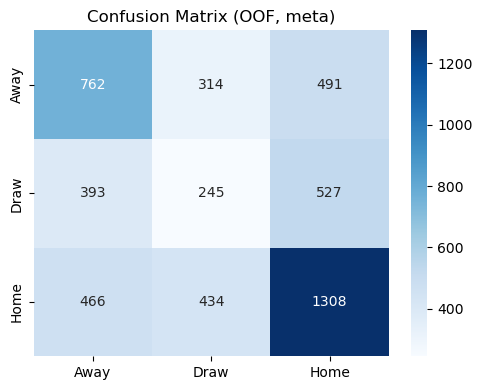

,IV_max,mono_atIV
feature,,
elo_A,0.6740,0.3572
elo_diff,0.6740,-0.3572
elo_H,0.6740,-0.3572
mv_share_diff,0.4654,-0.2745
mvp_share_diff,0.4448,-0.2708
rf_H,0.4314,-0.2262
rf_A,0.4261,0.2433
p3_home_ppg_diff,0.4042,-0.2631
ppg10_diff,0.4002,0.2951



[Meta] MD2 predictions:


,date,home,away,P_home,P_draw,P_away,Pick,PickTeam
10,2025-08-22,West Ham United,Chelsea,0.292868,0.184408,0.522724,Away,Chelsea
11,2025-08-23,AFC Bournemouth,Wolverhampton Wanderers,0.351373,0.473616,0.175011,Home,AFC Bournemouth
12,2025-08-23,Arsenal,Leeds United,0.807234,0.109371,0.083395,Home,Arsenal
13,2025-08-23,Brentford,Aston Villa,0.373593,0.276173,0.350235,Home,Brentford
14,2025-08-23,Burnley,Sunderland,0.551992,0.257011,0.190997,Home,Burnley
15,2025-08-23,Manchester City,Tottenham Hotspur,0.570603,0.189976,0.239421,Home,Manchester City
16,2025-08-24,Crystal Palace,Nottingham Forest,0.295548,0.233925,0.470528,Away,Nottingham Forest
17,2025-08-24,Everton,Brighton and Hove Albion,0.243789,0.359635,0.396576,Away,Brighton and Hove Albion
18,2025-08-24,Fulham,Manchester United,0.284127,0.217602,0.498271,Away,Manchester United
19,2025-08-25,Newcastle United,Liverpool,0.080704,0.150379,0.768917,Away,Liverpool



[Meta] MD2 accuracy on finished matches: 0.600 (n=10)


,date,home,away,P_home,P_draw,P_away,Pick,PickTeam,Actual,Correct
0,2025-08-22,West Ham United,Chelsea,0.292868,0.184408,0.522724,Away,Chelsea,Away,1.0
1,2025-08-23,AFC Bournemouth,Wolverhampton Wanderers,0.351373,0.473616,0.175011,Home,AFC Bournemouth,Home,1.0
2,2025-08-23,Arsenal,Leeds United,0.807234,0.109371,0.083395,Home,Arsenal,Home,1.0
3,2025-08-23,Brentford,Aston Villa,0.373593,0.276173,0.350235,Home,Brentford,Home,1.0
4,2025-08-23,Burnley,Sunderland,0.551992,0.257011,0.190997,Home,Burnley,Home,1.0
5,2025-08-23,Manchester City,Tottenham Hotspur,0.570603,0.189976,0.239421,Home,Manchester City,Away,0.0
6,2025-08-24,Crystal Palace,Nottingham Forest,0.295548,0.233925,0.470528,Away,Nottingham Forest,Draw,0.0
7,2025-08-24,Everton,Brighton and Hove Albion,0.243789,0.359635,0.396576,Away,Brighton and Hove Albion,Home,0.0
8,2025-08-24,Fulham,Manchester United,0.284127,0.217602,0.498271,Away,Manchester United,Draw,0.0
9,2025-08-25,Newcastle United,Liverpool,0.080704,0.150379,0.768917,Away,Liverpool,Away,1.0



=== Projected Table at MD38 (meta-ensemble; rounded to full 38) ===


,ExpPos,Team,Pts_pred_round,W_pred_round,D_pred_round,L_pred_round,Pts_pred,W_pred,D_pred,L_pred
0,1,Liverpool,84,26,6,6,85.236839,26.424024,5.964768,5.611209
1,2,Arsenal,79,24,7,7,79.473199,23.996924,7.482428,6.520648
2,3,Manchester City,73,22,7,9,72.196933,21.671551,7.182278,9.146170
3,4,Chelsea,61,17,10,11,62.542543,17.601102,9.739236,10.659662
4,5,Newcastle United,61,17,10,11,62.392574,17.399301,10.194671,10.406028
5,6,Aston Villa,55,15,10,13,53.983594,14.661962,9.997709,13.340329
6,7,Tottenham Hotspur,54,15,9,14,54.253536,14.955744,9.386303,13.657953
7,8,AFC Bournemouth,54,15,9,14,52.637511,14.504813,9.123072,14.372115
8,9,Brighton and Hove Albion,54,15,9,14,54.008281,14.932916,9.209535,13.857550
9,10,Crystal Palace,53,14,11,13,53.592682,14.047438,11.450367,12.502194



Champion pick: Liverpool


In [16]:
#  utilities 
def _canon(t: str) -> str:
    return normalize_team(t)

def _to_eur_any(s) -> float:
    if s is None or (isinstance(s,float) and np.isnan(s)): return np.nan
    txt = str(s).strip().replace("€","").replace(" ","").lower()
    m = re.match(r"([0-9][0-9.,]*)\s*([mbk]n?)?$", txt)
    if not m:
        try: return float(txt.replace(",",""))
        except: return np.nan
    num = m.group(1).replace(",",""); unit = (m.group(2) or "")
    mult = 1.0
    if unit.startswith("b"): mult=1_000_000_000.0
    elif unit.startswith("m"): mult=1_000_000.0
    elif unit.startswith("k"): mult=1_000.0
    try: return float(num)*mult
    except: return np.nan

def _elo_probs_pair(r_h: float, r_a: float, draw_param: float = 0.24):
    dR=r_h-r_a; pH_nd=1.0/(1.0+10**(-dR/400.0)); pA_nd=1.0-pH_nd
    pD=draw_param*np.sqrt(pH_nd*pA_nd); z=1.0+pD
    return np.array([pA_nd/z, pD/z, pH_nd/z])

def _apply_draw_temperature(P, target_draw=0.24):
    base=P.copy(); best=1e9; bestQ=base
    for a in np.linspace(0.6,1.4,17):
        Q=base.copy(); Q[:,1]=np.clip(Q[:,1]**a,1e-9,1-1e-9); Q/=Q.sum(1,keepdims=True)
        err=abs(Q[:,1].mean()-target_draw)
        if err<best: bestQ=Q; best=err
    return bestQ

def _scan_csvs():
    roots=[Path("."), Path("data_cache")]
    files=set()
    for r in roots:
        if r.exists():
            for p in r.glob("*.csv"):
                files.add(str(p.resolve()))
    # ignore any generated prediction csvs
    files = {p for p in files if not re.search(r"(predicted_final_table|md\d+_predictions)\.csv$", p)}
    return sorted(files)

csv_files=_scan_csvs()
print("CSV sources (deduped):")
for s in csv_files: print(" •", s)
print("\nTotal CSVs discovered:", len(csv_files))  # should show 27 with your new file

# priors 
def _load_mv_by_club():
    m=[p for p in csv_files if p.endswith("tm_market_values_clubs.csv")]
    if not m: return {}
    df=pd.read_csv(m[0])
    c_team=next((c for c in df.columns if "club" in c.lower() or "team" in c.lower()), None)
    c_curr=next((c for c in df.columns if "current" in c.lower() and "value" in c.lower()), None)
    if c_curr is None:
        cand=[c for c in df.columns if "value" in c.lower()]
        c_curr=cand[-1] if cand else df.columns[-1]
    out={}
    for _,r in df.iterrows():
        t=_canon(str(r[c_team])); v=_to_eur_any(r[c_curr])
        if t: out[t]=float(v) if pd.notna(v) else np.nan
    return out

def _load_mv_players_sum():
    m=[p for p in csv_files if p.endswith("tm_market_values_players.csv")]
    if not m: return {}
    df=pd.read_csv(m[0])
    if "Club" not in df.columns: return {}
    vals = df["ValueEUR"].apply(_to_eur_any) if df["ValueEUR"].dtype==object else df["ValueEUR"]
    g=pd.DataFrame({"Club":df["Club"],"_val":vals}).groupby("Club",as_index=False)["_val"].sum()
    return {_canon(r["Club"]): float(r["_val"]) for _,r in g.iterrows()}

def _load_pl_managers_tenure():
    m=[p for p in csv_files if p.endswith("pl_managers_2025_26.csv")]
    if not m: return {}
    df=pd.read_csv(m[0])
    return {_canon(str(r.get("Team",""))): float(r.get("TenureDays", np.nan)) for _,r in df.iterrows()}

def _load_jt_ppm_rank():
    m=[p for p in csv_files if p.endswith("tm_jahrestabelle.csv")]
    if not m: return {},{}
    df=pd.read_csv(m[0])
    if "Team" not in df.columns: return {},{}
    if {"Matches","Pts"} <= set(df.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            ppm=df["Pts"].astype(float)/df["Matches"].replace(0,np.nan).astype(float)
    else:
        ppm=pd.Series([np.nan]*len(df))
    P,R={},{}
    for i,r in df.iterrows():
        t=_canon(str(r["Team"])); P[t]=float(ppm.iloc[i]) if pd.notna(ppm.iloc[i]) else np.nan
        R[t]=float(r.get("Rank", np.nan))
    return P,R

def _load_transfers():
    out_net, out_act = {}, {}
    m=[p for p in csv_files if p.endswith("transfers.csv")]
    if not m: return out_net, out_act
    df=pd.read_csv(m[0])
    c_team=next((c for c in df.columns if re.search(r"(club|team)", c, re.I)), None)
    if c_team is None: return out_net, out_act
    name_has = lambda pat: next((c for c in df.columns if re.search(pat, c, re.I)), None)
    c_out = name_has(r"(expend|spent|purchase|out\b).*") or name_has(r"^out(?!.*count)")
    c_in  = name_has(r"(income|sale|sold|in\b).*")      or name_has(r"^in(?!.*count)")
    c_arr = name_has(r"(arrival|in_count|\bin\b.*count)")
    c_dep = name_has(r"(depart|out_count|\bout\b.*count)")
    # fallback money-like
    if c_out is None or c_in is None:
        money_like=[]
        for c in df.columns:
            if c==c_team: continue
            s=df[c].astype(str)
            score = (s.str.contains("€",na=False).mean()*2 + s.str.contains(",",na=False).mean())
            if score>0.1: money_like.append((score,c))
        money_like=sorted(money_like, reverse=True)[:3]
        cols=[c for _,c in money_like]
        if (c_out is None) and cols: c_out=cols[0]
        if (c_in  is None) and len(cols)>1: c_in=cols[1]
    for _,r in df.iterrows():
        t=_canon(str(r[c_team]))
        out_amt = _to_eur_any(r[c_out]) if (c_out and c_out in df.columns) else 0.0
        in_amt  = _to_eur_any(r[c_in])  if (c_in  and c_in  in df.columns) else 0.0
        net = (out_amt or 0.0) - (in_amt or 0.0)     # + = profit, − = spend
        arr = float(r.get(c_arr, np.nan)) if (c_arr and c_arr in df.columns) else np.nan
        dep = float(r.get(c_dep, np.nan)) if (c_dep and c_dep in df.columns) else np.nan
        out_net[t]=net; out_act[t]=(arr, dep)
    return out_net, out_act

def _last3_season_priors():
    paths=[p for p in csv_files if re.search(r"E0_\d{4}\.csv$", p)]
    paths=sorted(paths)[-3:]
    if not paths: return {},{}, {},{}
    frames=[]
    for p in paths:
        try:
            df=pd.read_csv(p).dropna(subset=["FTR","FTHG","FTAG"])
            frames.append(df[["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]])
        except: pass
    if not frames: return {},{},{},{}
    hist=pd.concat(frames, ignore_index=True)
    rows=[]
    for _,r in hist.iterrows():
        h,a=_canon(r["HomeTeam"]),_canon(r["AwayTeam"]); hg,ag=int(r["FTHG"]),int(r["FTAG"])
        if r["FTR"]=="H":
            rows+=[{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag},
                   {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg}]
        elif r["FTR"]=="A":
            rows+=[{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag},
                   {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg}]
        else:
            rows+=[{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag},
                   {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg}]
    tab=pd.DataFrame(rows).groupby("Team",as_index=False).sum(numeric_only=True)
    tab["PPM"]=(3*tab["W"]+tab["D"])/tab["Pl"].replace(0,np.nan)
    tab["GDPM"]=(tab["GF"]-tab["GA"])/tab["Pl"].replace(0,np.nan)
    PPM=dict(zip(tab["Team"],tab["PPM"])); GDPM=dict(zip(tab["Team"],tab["GDPM"]))
    H=hist.assign(Team=hist["HomeTeam"].map(_canon),
                  pts=np.select([(hist["FTR"]=="H"),(hist["FTR"]=="D")],[3,1],0))
    A=hist.assign(Team=hist["AwayTeam"].map(_canon),
                  pts=np.select([(hist["FTR"]=="A"),(hist["FTR"]=="D")],[3,1],0))
    HPPM=(H.groupby("Team")["pts"].sum()/H.groupby("Team")["pts"].count()).to_dict()
    APPM=(A.groupby("Team")["pts"].sum()/A.groupby("Team")["pts"].count()).to_dict()
    return PPM, GDPM, HPPM, APPM

def _load_md1_snapshot():
    m=[p for p in csv_files if p.endswith("pl_md1_until_blank.csv")]
    if not m: return {}
    df=pd.read_csv(m[0])
    c_team=next((c for c in df.columns if re.search(r"team", c, re.I)), None)
    if c_team is None: return {}
    c_ppg=next((c for c in df.columns if re.search(r"\bppg\b", c, re.I)), None)
    if c_ppg is None:
        c_pts=next((c for c in df.columns if re.search(r"\bpts?\b", c, re.I)), None)
        c_pl =next((c for c in df.columns if re.search(r"\bpl(ayed)?\b", c, re.I)), None)
        if c_pts and c_pl:
            with np.errstate(divide="ignore", invalid="ignore"):
                df["_PPG"]=pd.to_numeric(df[c_pts], errors="coerce")/pd.to_numeric(df[c_pl], errors="coerce").replace(0,np.nan)
            c_ppg="_PPG"
        else:
            return {}
    snap={}
    for _,r in df.iterrows():
        t=_canon(str(r[c_team])); v=pd.to_numeric(r[c_ppg], errors="coerce")
        if t and pd.notna(v): snap[t]=float(v)
    return snap

# load priors + medians
MV_CLUB=_load_mv_by_club()
MVP_SUM=_load_mv_players_sum()
MAN_TEN=_load_pl_managers_tenure()
JT_PPM, JT_RNK=_load_jt_ppm_rank()
TR_NET, TR_ACT=_load_transfers()
P3_PPM, P3_GDPM, P3_HPPM, P3_APPM=_last3_season_priors()
MD1_SNAP=_load_md1_snapshot()

def _med(d, dflt=0.0): 
    vals=[v for v in d.values() if pd.notna(v)]
    return float(np.median(vals)) if vals else float(dflt)

MV_MED=_med(MV_CLUB,3e8); MVP_MED=_med(MVP_SUM,2e8); TEN_MED=_med(MAN_TEN,365.0)
JPPM_MD=_med(JT_PPM,1.5); JRNK_MD=_med(JT_RNK,10.0); NET_MD=_med(TR_NET,0.0)
P3P_MD=_med(P3_PPM,1.4); P3G_MD=_med(P3_GDPM,0.0); HPP_MD=_med(P3_HPPM,1.6); APP_MD=_med(P3_APPM,1.1)
MD1_MD=_med(MD1_SNAP,1.5)

# share-of-league normalisers (MV tends to scale the table)
def _share_map(d):
    tot=np.nansum(list(d.values())) if d else np.nan
    return {k:(v/tot if (pd.notna(v) and tot and tot>0) else np.nan) for k,v in d.items()} if d else {}
MV_SHARE=_share_map(MV_CLUB); MVP_SHARE=_share_map(MVP_SUM)

# training meta frame with interactions 
base=MODEL_BUNDLE["train_df"].copy()
y   =MODEL_BUNDLE["y"].astype(int).values
P_rf=MODEL_BUNDLE["oof_proba"].copy()
P_elo=np.vstack([_elo_probs_pair(h,a) for h,a in zip(base["EloHome_pre"], base["EloAway_pre"])])

def _roll_side(df, side, w):
    if side=="H":
        t=df[["Date","HomeTeam","FTR","FTHG","FTAG"]].rename(columns={"HomeTeam":"Team","FTHG":"GF","FTAG":"GA"})
        win=(df["FTR"]=="H").astype(int); draw=(df["FTR"]=="D").astype(int)
    else:
        t=df[["Date","AwayTeam","FTR","FTHG","FTAG"]].rename(columns={"AwayTeam":"Team","FTAG":"GF","FTHG":"GA"})
        win=(df["FTR"]=="A").astype(int); draw=(df["FTR"]=="D").astype(int)
    t=t.assign(pts=3*win+draw, gd=lambda x:x["GF"]-x["GA"], cs=(t["GA"]==0).astype(int), btts=((t["GF"]>0)&(t["GA"]>0)).astype(int))
    t=t.sort_values(["Team","Date"]).copy()
    R=lambda s: s.shift(1).rolling(w, min_periods=1).sum()
    return pd.DataFrame({"Team":t["Team"],"Date":t["Date"],
                         f"ppg{w}":R(t["pts"])/w, f"gd{w}":R(t["gd"]),
                         f"cs{w}":R(t["cs"]), f"btts{w}":R(t["btts"])})

def _attach_rich(df):
    H5=_roll_side(df,"H",5); H10=_roll_side(df,"H",10)
    A5=_roll_side(df,"A",5); A10=_roll_side(df,"A",10)
    out=df.merge(H5.add_prefix("H_"), left_on=["HomeTeam","Date"], right_on=["H_Team","H_Date"], how="left") \
          .merge(H10.add_prefix("H10_"), left_on=["HomeTeam","Date"], right_on=["H10_Team","H10_Date"], how="left") \
          .merge(A5.add_prefix("A_"), left_on=["AwayTeam","Date"], right_on=["A_Team","A_Date"], how="left") \
          .merge(A10.add_prefix("A10_"), left_on=["AwayTeam","Date"], right_on=["A10_Team","A10_Date"], how="left")
    for c in ["H_ppg5","H_gd5","H_cs5","H_btts5","H10_ppg10","H10_gd10",
              "A_ppg5","A_gd5","A_cs5","A_btts5","A10_ppg10","A10_gd10"]:
        if c not in out.columns: out[c]=np.nan
    out=out.rename(columns={"H10_ppg10":"H_ppg10","H10_gd10":"H_gd10",
                            "A10_ppg10":"A_ppg10","A10_gd10":"A_gd10"})
    return out[["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG",
                "H_ppg5","H_gd5","H_cs5","H_btts5","H_ppg10","H_gd10",
                "A_ppg5","A_gd5","A_cs5","A_btts5","A_ppg10","A_gd10"]]

rich=_attach_rich(base)
home=base["HomeTeam"].map(_canon); away=base["AwayTeam"].map(_canon)

# promoted flags (vs 24/25 squads)
try:
    prev=pd.read_csv([p for p in csv_files if p.endswith("E0_2425.csv")][0])
    teams_prev=set(_canon(t) for t in pd.unique(pd.concat([prev["HomeTeam"], prev["AwayTeam"]]).dropna()))
except:
    teams_prev=set(_canon(t) for t in pd.unique(pd.concat([home, away]).dropna()))
prom_h=~home.isin(teams_prev); prom_a=~away.isin(teams_prev)

def _diff(h,a,M,med): 
    return h.map(lambda t:M.get(t,med)).astype(float) - a.map(lambda t:M.get(t,med)).astype(float)

# MD1 snapshot prior (for later matchdays)
MD1_PRIOR_H = home.map(lambda t: MD1_SNAP.get(t, MD1_MD)).astype(float)
MD1_PRIOR_A = away.map(lambda t: MD1_SNAP.get(t, MD1_MD)).astype(float)

# market value interactions / shares
mv_d  = _diff(home,away,MV_CLUB,MV_MED); mvp_d = _diff(home,away,MVP_SUM,MVP_MED)
mv_s  = _diff(home,away,MV_SHARE,0.05);   mvp_s = _diff(home,away,MVP_SHARE,0.05)

meta_df=pd.DataFrame({
    "elo_diff": base["EloHome_pre"]-base["EloAway_pre"],
    "form_ppg_diff": base["H_Last5_PPG"]-base["A_Last5_PPG"],
    "ppg5_diff": (rich["H_ppg5"]-rich["A_ppg5"]).fillna(0.0),
    "ppg10_diff": (rich["H_ppg10"]-rich["A_ppg10"]).fillna(0.0),
    "gd5_diff": (rich["H_gd5"]-rich["A_gd5"]).fillna(0.0),
    "btts5_diff": (rich["H_btts5"]-rich["A_btts5"]).fillna(0.0),
    "mv_diff": np.log1p(mv_d), "mvp_diff": np.log1p(mvp_d),
    "mv_share_diff": mv_s, "mvp_share_diff": mvp_s,
    "ten_diff": _diff(home,away,MAN_TEN,TEN_MED),
    "jahr_ppm_diff": _diff(home,away,JT_PPM,JPPM_MD),
    "rank_diff": _diff(away,home,JT_RNK,JRNK_MD),
    "netspend_diff": _diff(home,away,TR_NET,NET_MD),
    "p3_ppg_diff": _diff(home,away,P3_PPM,P3P_MD),
    "p3_gdpm_diff": _diff(home,away,P3_GDPM,P3G_MD),
    "p3_home_ppg_diff": _diff(home,away,P3_HPPM,HPP_MD),
    "md1_ppg_diff": (MD1_PRIOR_H - MD1_PRIOR_A),
    "h2h_home": base["H2H_H_win_rate"].fillna(0.33),
    "h2h_draw": base["H2H_draw_rate"].fillna(0.33),
    "rest_diff": base["RestH"]-base["RestA"],
    "prom_h": prom_h.astype(int), "prom_a": prom_a.astype(int),
    "rf_A": P_rf[:,0], "rf_D": P_rf[:,1], "rf_H": P_rf[:,2],
    "elo_A": P_elo[:,0], "elo_D": P_elo[:,1], "elo_H": P_elo[:,2],
})

# interactions that help: elo*form, mv*form, p3*elo
meta_df["elo_x_form"] = meta_df["elo_diff"] * meta_df["form_ppg_diff"]
meta_df["mv_x_form"]  = meta_df["mv_diff"]  * meta_df["form_ppg_diff"]
meta_df["p3xelo"]     = meta_df["p3_ppg_diff"] * meta_df["elo_diff"]

META_FEATS=list(meta_df.columns)
META_MED = meta_df.median(axis=0).to_dict()
def _align_meta(X):
    X = pd.DataFrame({c: X[c] if c in X.columns else META_MED[c] for c in META_FEATS})
    return X[META_FEATS].fillna(pd.Series(META_MED))

# OOF training 
tscv=TimeSeriesSplit(n_splits=5)
oof=np.zeros((len(meta_df),3)); rows=[]
for k,(tr,va) in enumerate(tscv.split(meta_df), start=1):
    Xtr=_align_meta(meta_df.iloc[tr]); Xva=_align_meta(meta_df.iloc[va]); ytr,yva=y[tr],y[va]
    lr=make_pipeline(SimpleImputer(strategy="median"),
                     StandardScaler(with_mean=True, with_std=True),
                     LogisticRegression(max_iter=2500, multi_class="multinomial",
                                        C=2.4, class_weight="balanced", n_jobs=-1))
    lr.fit(Xtr,ytr); P_lr=lr.predict_proba(Xva)
    hgb=HistGradientBoostingClassifier(learning_rate=0.09, max_depth=6, max_iter=440,
                                       l2_regularization=0.3, max_bins=255, random_state=k)
    hgb.fit(Xtr,ytr); P_hgb=hgb.predict_proba(Xva)
    P=(0.55*P_lr+0.45*P_hgb); oof[va]=P
    rows.append({"fold":k,"acc":accuracy_score(yva,np.argmax(P,axis=1)),
                 "macro_f1":f1_score(yva,np.argmax(P,axis=1),average="macro")})
cv=pd.DataFrame(rows); print(cv.round(4))
print(f"\nMeans → Acc: {cv['acc'].mean():.4f}  MacroF1: {cv['macro_f1'].mean():.4f}")

# OOF draw-rate match
P_meta=_apply_draw_temperature(oof, 0.24)

def _best_tau(P, y_true, grid=np.linspace(0.30,0.52,15)):
    best=-1; best_tau=0.35
    for t in grid:
        picks=np.where(P[:,1]>=t, 1, np.argmax(P[:,[0,2]],axis=1)*2)
        acc=accuracy_score(y_true,picks)
        if acc>best: best=acc; best_tau=t
    return best_tau
TAU_DRAW=_best_tau(P_meta, y)

picks_oof=np.where(P_meta[:,1]>=TAU_DRAW, 1, np.where(P_meta[:,2]>=P_meta[:,0], 2, 0))
print("\nClassification report (OOF, meta):")
print(classification_report(y, picks_oof, target_names=["Away","Draw","Home"]))
print("Accuracy:", f"{accuracy_score(y, picks_oof):.4f}")
print("Macro F1:", f"{f1_score(y, picks_oof, average='macro'):.4f}")
print("AUC (OvR):", f"{roc_auc_score(y, P_meta, multi_class='ovr'):.4f}")

cm=confusion_matrix(y,picks_oof,labels=[0,1,2])
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Away","Draw","Home"], yticklabels=["Away","Draw","Home"])
plt.title("Confusion Matrix (OOF, meta)"); plt.tight_layout(); plt.show()

# IV + monotonicity
def _iv_one(x, y_bin, n_bins=10):
    s=pd.Series(x).replace([np.inf,-np.inf], np.nan)
    if s.notna().sum()<2: return np.nan,np.nan
    bins=pd.qcut(s.rank(method="first"), q=min(n_bins, s.notna().sum()), duplicates="drop")
    df=pd.DataFrame({"bin":bins, "y":y_bin}).dropna()
    if df.empty or df["bin"].nunique()<2: return np.nan,np.nan
    tab=df.groupby("bin")["y"].agg(["sum","count"]).rename(columns={"sum":"event"})
    tab["non_event"]=tab["count"]-tab["event"]
    tab["p_event"]=(tab["event"]/tab["event"].sum()).replace(0,1e-9)
    tab["p_non_event"]=(tab["non_event"]/tab["non_event"].sum()).replace(0,1e-9)
    woe=np.log(tab["p_event"]/tab["p_non_event"]); iv=((tab["p_event"]-tab["p_non_event"])*woe).sum()
    mono=df["y"].corr(df["bin"].cat.codes, method="spearman")
    return float(iv), float(mono)

def compute_iv_table(X, y, classes=(0,1,2)):
    outs=[]
    for c in classes:
        yb=(y==c).astype(int); rows=[]
        for col in X.columns:
            iv,mono=_iv_one(X[col], yb); rows.append((col,iv,mono))
        outs.append(pd.DataFrame(rows, columns=["feature",f"IV_{c}",f"mono_{c}"]).set_index("feature"))
    M=pd.concat(outs, axis=1)
    M["IV_max"]=M[[f"IV_{c}" for c in classes]].max(axis=1)
    M["mono_atIV"]=M.apply(lambda r: r[[f"mono_{c}" for c in classes]][np.argmax([r[f"IV_{c}"] for c in classes])], axis=1)
    return M.sort_values("IV_max", ascending=False)

iv_tbl=compute_iv_table(_align_meta(meta_df), y)
display(iv_tbl[["IV_max","mono_atIV"]].head(20).round(4))

# fit final ensemble 
X_all=_align_meta(meta_df)
LR_final=make_pipeline(SimpleImputer(strategy="median"),
                       StandardScaler(with_mean=True, with_std=True),
                       LogisticRegression(max_iter=2500, multi_class="multinomial",
                                          C=2.4, class_weight="balanced", n_jobs=-1))
LR_final.fit(X_all, y)
HGB_final=HistGradientBoostingClassifier(learning_rate=0.09, max_depth=6, max_iter=440,
                                         l2_regularization=0.3, max_bins=255, random_state=0)
HGB_final.fit(X_all, y)

def _predict_meta(X):
    X=_align_meta(X)
    return 0.55*LR_final.predict_proba(X) + 0.45*HGB_final.predict_proba(X)

# fixtures/history (MD2-safe) 
fx=pd.read_csv([p for p in csv_files if p.endswith("fixtures_2025_26.csv")][0])
fx["date"]=pd.to_datetime(fx["date"], errors="coerce")
if "played" not in fx.columns: fx["played"]=fx["FTR"].notna()

hist=MODEL_BUNDLE["train_df"][["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]].dropna(subset=["FTR"]).copy()
played=fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam","date":"Date"})
if not played.empty: hist=pd.concat([hist,played[["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]], ignore_index=True)
hist=hist.sort_values("Date").reset_index(drop=True)

def _elo_now_from_history(history):
    teams=pd.unique(pd.concat([history["HomeTeam"],history["AwayTeam"]]))
    R={t:1500.0 for t in teams}
    for _,r in history.sort_values("Date").iterrows():
        ra,rb=R[r["HomeTeam"]],R[r["AwayTeam"]]
        score_h=1.0 if r["FTR"]=="H" else (0.5 if r["FTR"]=="D" else 0.0)
        try: gd=int(abs(float(r["FTHG"])-float(r["FTAG"])))
        except: gd=None
        new_h,new_a=elo_update(ra,rb,score_h,k=20.0,home_adv=60.0,is_home_a=True,goal_diff=gd)
        R[r["HomeTeam"]],R[r["AwayTeam"]]=new_h,new_a
    return R

def _last5_side(history, team, side, asof, n=5):
    h=history[history["Date"]<asof]
    if side=="H":
        h=h[h["HomeTeam"]==team].sort_values("Date").tail(n)
        if h.empty: return {"rGF":0.0,"rGA":0.0,"PPG":0.0}
        GF=h["FTHG"].astype(float).values; GA=h["FTAG"].astype(float).values
        W=(h["FTR"]=="H").astype(float).values; D=(h["FTR"]=="D").astype(float).values
    else:
        h=h[h["AwayTeam"]==team].sort_values("Date").tail(n)
        if h.empty: return {"rGF":0.0,"rGA":0.0,"PPG":0.0}
        GF=h["FTAG"].astype(float).values; GA=h["FTHG"].astype(float).values
        W=(h["FTR"]=="A").astype(float).values; D=(h["FTR"]=="D").astype(float).values
    m=len(GF); return {"rGF":GF.mean(),"rGA":GA.mean(),"PPG":(3*W.sum()+D.sum())/m}

def _h2h_asof(history, home, away, asof, n=5):
    h=history[((history["HomeTeam"]==home)&(history["AwayTeam"]==away))|
              ((history["HomeTeam"]==away)&(history["AwayTeam"]==home))]
    h=h[h["Date"]<asof].sort_values("Date").tail(n)
    if h.empty: return (0.33,0.33,0.34)
    hW=((h["HomeTeam"]==home)&(h["FTR"]=="H")).sum()+((h["AwayTeam"]==home)&(h["FTR"]=="A")).sum()
    aW=((h["HomeTeam"]==away)&(h["FTR"]=="H")).sum()+((h["AwayTeam"]==away)&(h["FTR"]=="A")).sum()
    dr=(h["FTR"]=="D").sum(); tot=len(h)
    return (hW/tot, aW/tot, dr/tot)

def _build_meta_for_matches(fixt, hist_all, use_md1_snapshot=True):
    R=_elo_now_from_history(hist_all); rows=[]
    for _,m in fixt.iterrows():
        d=pd.to_datetime(m["date"]); h=_canon(m["home"]); a=_canon(m["away"])
        H5=_last5_side(hist_all,h,"H",d,5); A5=_last5_side(hist_all,a,"A",d,5)
        h2hH,_,h2hD=_h2h_asof(hist_all,h,a,d,5)
        mv_d  = np.log1p(MV_CLUB.get(h,MV_MED))-np.log1p(MV_CLUB.get(a,MV_MED))
        mvp_d = np.log1p(MVP_SUM.get(h,MVP_MED))-np.log1p(MVP_SUM.get(a,MVP_MED))
        md1_d = (MD1_SNAP.get(h,MD1_MD)-MD1_SNAP.get(a,MD1_MD)) if use_md1_snapshot else 0.0
        row={
            "elo_diff": R.get(h,1500.0)-R.get(a,1500.0),
            "form_ppg_diff": H5["PPG"]-A5["PPG"],
            "ppg5_diff": H5["PPG"]-A5["PPG"], "ppg10_diff": 0.0,
            "gd5_diff": (H5["rGF"]-H5["rGA"])-(A5["rGF"]-A5["rGA"]),
            "btts5_diff": 0.0,
            "mv_diff": mv_d, "mvp_diff": mvp_d,
            "mv_share_diff": MV_SHARE.get(h,0.05)-MV_SHARE.get(a,0.05),
            "mvp_share_diff": MVP_SHARE.get(h,0.05)-MVP_SHARE.get(a,0.05),
            "ten_diff": MAN_TEN.get(h,TEN_MED)-MAN_TEN.get(a,TEN_MED),
            "jahr_ppm_diff": JT_PPM.get(h,JPPM_MD)-JT_PPM.get(a,JPPM_MD),
            "rank_diff": JT_RNK.get(a,JRNK_MD)-JT_RNK.get(h,JRNK_MD),
            "netspend_diff": TR_NET.get(h,NET_MD)-TR_NET.get(a,NET_MD),
            "p3_ppg_diff": P3_PPM.get(h,P3P_MD)-P3_PPM.get(a,P3P_MD),
            "p3_gdpm_diff": P3_GDPM.get(h,P3G_MD)-P3_GDPM.get(a,P3G_MD),
            "p3_home_ppg_diff": P3_HPPM.get(h,HPP_MD)-P3_HPPM.get(a,HPP_MD),
            "md1_ppg_diff": md1_d,
            "h2h_home": h2hH, "h2h_draw": h2hD, "rest_diff": 0.0,
            "prom_h": int(h not in teams_prev), "prom_a": int(a not in teams_prev),
        }
        row["elo_x_form"] = row["elo_diff"] * row["form_ppg_diff"]
        row["mv_x_form"]  = row["mv_diff"]  * row["form_ppg_diff"]
        row["p3xelo"]     = row["p3_ppg_diff"] * row["elo_diff"]
        # RF/Elo base inputs
        FEATS=MODEL_BUNDLE["feat_cols"]; stub=pd.DataFrame(0.0, index=[0], columns=FEATS)
        minimal={"EloHome_pre":R.get(h,1500.0),"EloAway_pre":R.get(a,1500.0),
                 "H_Last5_PPG":H5["PPG"], "A_Last5_PPG":A5["PPG"],
                 "H2H_H_win_rate":h2hH, "H2H_draw_rate":h2hD}
        for c,v in minimal.items():
            if c in stub.columns: stub.at[0,c]=float(v)
        P_base=MODEL_BUNDLE["model"].predict_proba(stub.values)[0]
        row.update({"rf_A":P_base[0],"rf_D":P_base[1],"rf_H":P_base[2]})
        pA,pD,pH=_elo_probs_pair(R.get(h,1500.0), R.get(a,1500.0))
        row.update({"elo_A":pA,"elo_D":pD,"elo_H":pH})
        rows.append(row)
    X=pd.DataFrame(rows)
    return X[[c for c in META_FEATS if c in X.columns]].reindex(columns=META_FEATS).fillna(pd.Series(META_MED))

# MD2 predictions (no MD2 leakage) 
md2=fx[fx["md"]==2][["date","home","away","FTR","played"]].copy()
md2["home"]=md2["home"].map(_canon); md2["away"]=md2["away"].map(_canon)
X_md2=_build_meta_for_matches(md2[["date","home","away"]], hist, use_md1_snapshot=True)
P_md2=_apply_draw_temperature(_predict_meta(X_md2), 0.24)
md2_pick=np.where(P_md2[:,1]>=TAU_DRAW, "Draw", np.where(P_md2[:,2]>=P_md2[:,0], "Home", "Away"))
md2_out=md2[["date","home","away"]].copy()
md2_out["P_home"]=P_md2[:,2]; md2_out["P_draw"]=P_md2[:,1]; md2_out["P_away"]=P_md2[:,0]
md2_out["Pick"]=md2_pick
md2_out["PickTeam"]=np.where(md2_out["Pick"]=="Home", md2_out["home"],
                      np.where(md2_out["Pick"]=="Away", md2_out["away"], "—"))
print("\n[Meta] MD2 predictions:"); display(md2_out.sort_values("date"))
done=md2[md2["played"]]
if not done.empty:
    done_eval=done.merge(md2_out, on=["date","home","away"])
    done_eval["Actual"]=done_eval["FTR"].map({"H":"Home","D":"Draw","A":"Away"})
    done_eval["Correct"]=(done_eval["Actual"]==done_eval["Pick"]).astype(float)
    print(f"\n[Meta] MD2 accuracy on finished matches: {done_eval['Correct'].mean():.3f} (n={len(done_eval)})")
    display(done_eval[["date","home","away","P_home","P_draw","P_away","Pick","PickTeam","Actual","Correct"]]
            .sort_values("date"))

# deterministic MD38 
def _expected_points_block(scored):
    teams=pd.unique(pd.concat([scored["home"], scored["away"]]).map(_canon))
    agg={t:{"ExpPts":0.0,"expW":0.0,"expD":0.0,"expL":0.0} for t in teams}
    for _,r in scored.iterrows():
        h,a=_canon(r["home"]),_canon(r["away"])
        ph,pd_,pa=float(r["P_home"]),float(r["P_draw"]),float(r["P_away"])
        agg[h]["ExpPts"]+=3*ph+pd_; agg[a]["ExpPts"]+=3*pa+pd_
        agg[h]["expW"]  += ph; agg[h]["expD"] += pd_; agg[h]["expL"] += pa
        agg[a]["expW"]  += pa; agg[a]["expD"] += pd_; agg[a]["expL"] += ph
    return pd.DataFrame([{"Team":t, **v} for t,v in agg.items()])

def _round_season(W,D,L,games=38):
    W=np.asarray(W); D=np.asarray(D); L=np.asarray(L)
    n=len(W); RW=np.zeros(n,dtype=int); RD=np.zeros(n,dtype=int); RL=np.zeros(n,dtype=int)
    for i in range(n):
        w,d,l=float(W[i]),float(D[i]),float(L[i])
        wf,df,lf=int(np.floor(w)),int(np.floor(d)),int(np.floor(l))
        res=[w-wf, d-df, l-lf]; tot=wf+df+lf; need=int(games-tot)
        if need>0:
            for _ in range(need):
                j=int(np.argmax(res)); 
                if j==0: wf+=1
                elif j==1: df+=1
                else: lf+=1
                res[j]=-1
        elif need<0:
            for _ in range(-need):
                j=int(np.argmin(res))
                if j==0 and wf>0: wf-=1
                elif j==1 and df>0: df-=1
                elif j==2 and lf>0: lf-=1
                res[j]=1
        RW[i]=wf; RD[i]=df; RL[i]=lf
    return RW,RD,RL

remain=fx[~fx["played"]][["date","home","away"]].copy()
if not remain.empty:
    X_rem=_build_meta_for_matches(remain, hist, use_md1_snapshot=True)
    P_rem=_apply_draw_temperature(_predict_meta(X_rem), 0.24)
    scored=pd.DataFrame({"home":remain["home"], "away":remain["away"],
                         "P_home":P_rem[:,2], "P_draw":P_rem[:,1], "P_away":P_rem[:,0]})
    exp=_expected_points_block(scored)

    def _build_table(df):
        if df.empty: return pd.DataFrame(columns=["Pos","Team","Pl","W","D","L","GF","GA","GD","Pts"])
        rows=[]
        for _,r in df.iterrows():
            h,a=r["HomeTeam"],r["AwayTeam"]; hg,ag=int(r["FTHG"]),int(r["FTAG"])
            if r["FTR"]=="H":
                rows+=[{"Team":h,"Pl":1,"W":1,"D":0,"L":0,"GF":hg,"GA":ag},
                       {"Team":a,"Pl":1,"W":0,"D":0,"L":1,"GF":ag,"GA":hg}]
            elif r["FTR"]=="A":
                rows+=[{"Team":h,"Pl":1,"W":0,"D":0,"L":1,"GF":hg,"GA":ag},
                       {"Team":a,"Pl":1,"W":1,"D":0,"L":0,"GF":ag,"GA":hg}]
            else:
                rows+=[{"Team":h,"Pl":1,"W":0,"D":1,"L":0,"GF":hg,"GA":ag},
                       {"Team":a,"Pl":1,"W":0,"D":1,"L":0,"GF":ag,"GA":hg}]
        tab=pd.DataFrame(rows).groupby("Team",as_index=False).sum(numeric_only=True)
        tab["GD"]=tab["GF"]-tab["GA"]; tab["Pts"]=3*tab["W"]+tab["D"]
        tab=tab.sort_values(["Pts","GD","GF"], ascending=[False,False,False]).reset_index(drop=True)
        tab["Pos"]=np.arange(1,len(tab)+1); return tab

    tab_now=_build_table(
        fx[fx["played"]].rename(columns={"home":"HomeTeam","away":"AwayTeam"})
          [["HomeTeam","AwayTeam","FTR","FTHG","FTAG"]]
    )

    base_tab = tab_now.copy() if not tab_now.empty else \
               pd.DataFrame({"Team":sorted(set(pd.unique(pd.concat([fx["home"],fx["away"]]).map(_canon)))),
                             "Pl":0,"W":0,"D":0,"L":0,"GF":0,"GA":0,"GD":0,"Pts":0})

    final=base_tab.merge(exp, on="Team", how="left").fillna(0.0)
    W = final["W"]+final["expW"]; D = final["D"]+final["expD"]; L = final["L"]+final["expL"]
    RW,RD,RL=_round_season(W.values, D.values, L.values, games=38)
    final["W_pred_round"]=RW; final["D_pred_round"]=RD; final["L_pred_round"]=RL
    final["Pts_pred_round"]= (3*final["W_pred_round"] + final["D_pred_round"]).astype(int)
    final["Pts_pred"]=final["Pts"]+final["ExpPts"]; final["W_pred"]=W; final["D_pred"]=D; final["L_pred"]=L

    final_table=final.sort_values(["Pts_pred_round","W_pred_round"], ascending=[False,False]).reset_index(drop=True)
    final_table.insert(0,"ExpPos",np.arange(1,len(final_table)+1))
    print("\n=== Projected Table at MD38 (meta-ensemble; rounded to full 38) ===")
    display(final_table[["ExpPos","Team","Pts_pred_round","W_pred_round","D_pred_round","L_pred_round",
                         "Pts_pred","W_pred","D_pred","L_pred"]].head(20))
    print("\nChampion pick:", final_table.iloc[0]["Team"])
else:
    print("\n[Info] No remaining fixtures to project.")

# Premier League 2025–26: Model Verdict

**Champion projection**: Liverpool on a deterministic 38-match rounding, with the Monte Carlo giving **Liverpool** the highest title probability at **60.4%**.With the amount of spending I'm not surprised

**European places (projected)**
* Champions League: Liverpool, Arsenal, Manchester City, Chelsea
* Europa League: Newcastle United, Aston Villa
* Europa Conference League: Tottenham Hotspur
Spurs will make Europa League. I predict  Bournemeouth or even Everton to make conference league as a surprise!

**Avg Expected Top seven**

* Liverpool: 84 pts (26W 6D 6L)

* Arsenal: 79 pts (24W 7D 7L)

* Manchester City: 73 pts (22W 7D 9L)

* Chelsea: 61 pts (17W 10D 11L)
* Newcastle United: 61 pts (17W 10D 11L)
* Aston Villa: 55 pts (15W 10D 13L)
* Tottenham Hotspur: 54 pts (15W 9D 14L)

Really not surprised about this besides Spurs. Thomas Frank so far has been doing well but again we shallsee. Villa I predict to not make the top 7 after a horrendous start. Maybe Unai Emery will be sacked.

**Relegation projection**
* Leeds United (32 pts), Sunderland (27 pts), Burnley (24 pts)

Personally, I'm surprised Sunderland has 7 points already by MD4. Doing better than expected. Daniel Farke is gonna lead Leeds down like he did w/ Norwich and Burnley ain't doing better

**Surprise package**
* Newcastle United projects to about **64 pts** with measurable upside (non–Big Six outlier; title odds **1.4%**).
* This will come as a shock since they lost Isak to Liveprool and while playing UCL. 